In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

# Make multihist even easier to use
from contextlib import contextmanager
@contextmanager
def plotting2d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global mh
    mh.plot(log_scale = True, cmap=plt.get_cmap('viridis'), alpha = 1.0 )

@contextmanager
def plotting1d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global ph
    ph.plot()

### Prospective S2 Single Scatter Cut

- Tianyu Jun 13
- Updated Jun 22 section E) and following


#### Motivation

- With the knowledge of that single electrons and multi-electron-pile-up's making up the mojority of S2 background, here we try to quantify the probability of the other largest S2s being just a single electron peak or a multi-electron-pile-up.

- On the other hand we can still assume a true scatter (other than the largest S2) would follow the diffussion model [link here](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:yuehuan:analysis:0sciencerun_s2width_update0)
Thus providing us one of the ways to quantitatively describle whether a peak is a true scatter or not.

- In this work, we would also like to include multiple S2s (just 1 peak for now) into our consideration and possibly give a better rejection power of multiple scatter.

The the main purpose of the cut proposed here is to distinguish between single electron, pile-up and a true scatter. The figures shown below depict those cases, as a true scatter would be larger, and have an expected width from diffusion model, while single electron and pile-up would have other features.

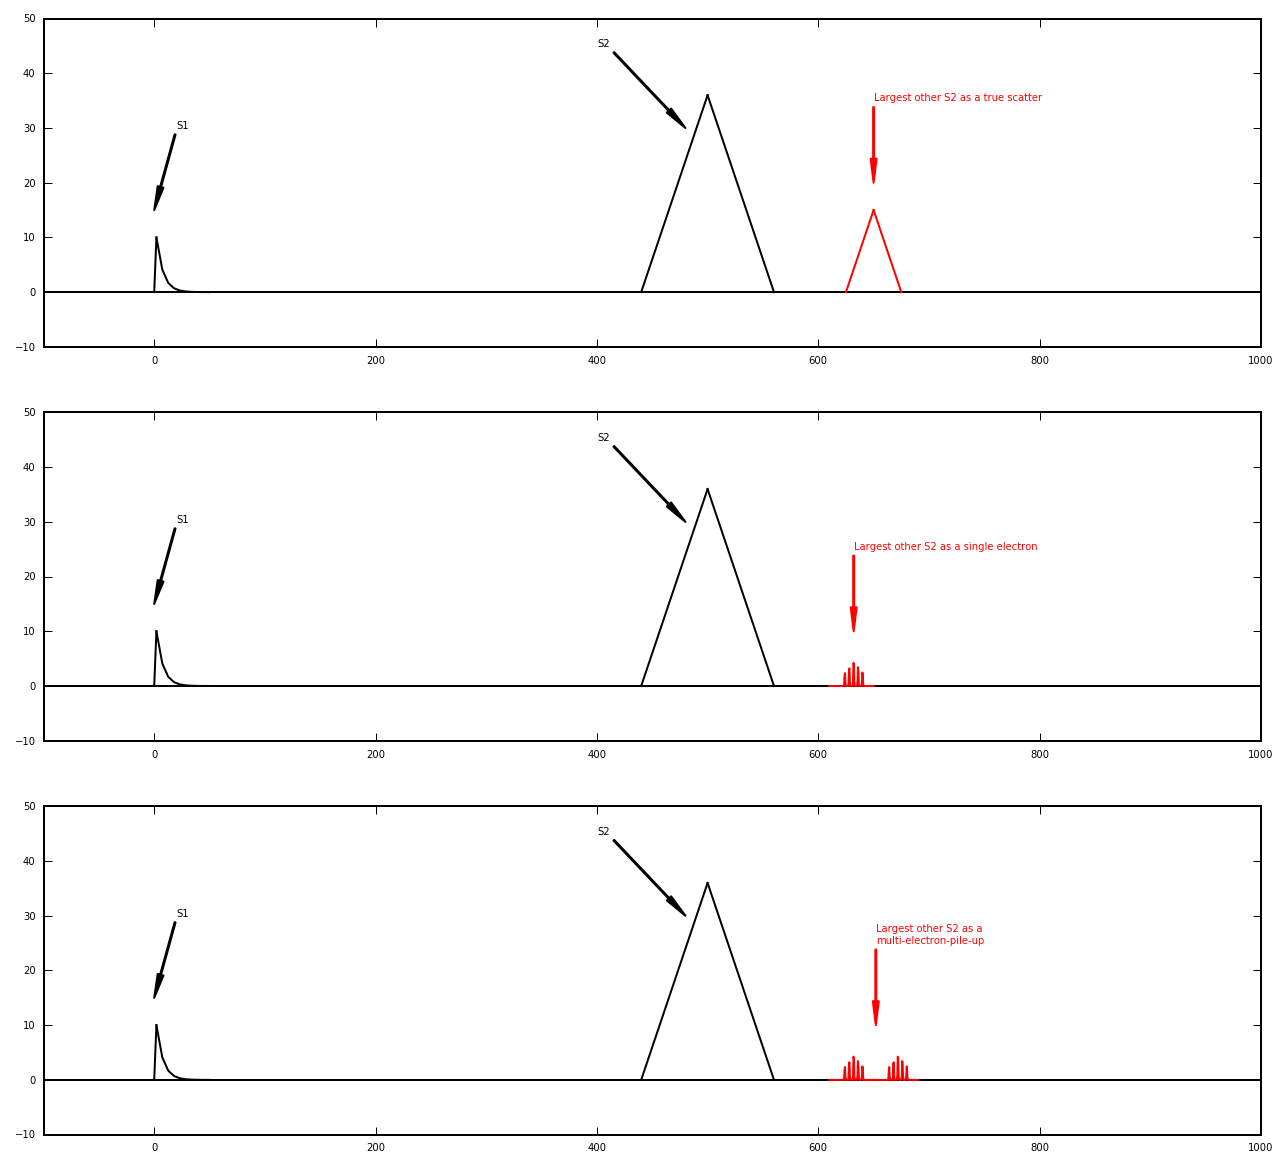

In [3]:
# Make some figures for demo
plt.rcParams['figure.figsize'] = (24, 10)
plt.rcParams['font.size'] = 5
fig = plt.figure()

def plot_s1(time):
    x = np.linspace(time,time+2,10)
    plt.plot(x, 5*(x-time), 'k-')
    x = np.linspace(time+2,time+50,10)
    plt.plot(x, 10*np.exp(-(x-time-2)/6),'k-')
    
def plot_s2(time,h = 36, c = 'k'):
    x = np.linspace(time-h/0.6,time,10)
    plt.plot(x,h+0.6*(x-time),'-',color = c)
    x = np.linspace(time,time+h/0.6,10)
    plt.plot(x,h-0.6*(x-time),'-',color = c)
    
def plot_se(time,c = 'r'):
    x = np.linspace(time-10,time+30,100)   
    def g(x,mu,a):
        return np.exp(-(x-mu)**2/0.2)*a
    y=0
    for mu in time + np.asarray([1,2,3,4,5])*4:
        y+=g(x,mu,5-abs(mu-time-12)*0.3)
        
    plt.plot(x,y,'-',color = c)

ax = fig.add_subplot(321)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_s2(650,h = 15,c = 'r')
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a true scatter', xy=(650, 20), xytext=(650, 35), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))



ax = fig.add_subplot(323)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_se(620)
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a single electron', xy=(632, 10), xytext=(632, 25), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))



ax = fig.add_subplot(325)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_se(620)

plot_se(660)
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a \nmulti-electron-pile-up', xy=(652, 10), xytext=(652, 25), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))


plt.show()

__Notes__:

- This note is focusing at low energy (s1 < 500 pe, s2 < 1000 pe) events, the benefit of this is that it allows us to ignore the affect from gate photo-ionization as well as pmt after-pulses which are both on ~0.1% level __(I am not sure about the pmt after pulse)__ and corresponds to single electrons rather than even bigger peaks.

- The transition from background S2s to photo-ionization peaks, might gives us the insight of  why earlier S2 single scatter cut study yielded segmented cut.


#### Procedure

__A)__  __Load data processed by pax v6.6.5__

Before this note, data have already gone through

__Cuts, includeing__ : InteractionExists, FiducialCylinder1T, S2Width, BusyTypeCheck, S2Threshold, BusyCheck, HEVCheck, S2AreaFractionTop

__Extracted extra infomation for this cut__ :
     - s2_x_y

    x denotes the order of the area of the peak:
     - 1: The 1st largest among peaks other than main interaction peak
     - 2: The 2nd largest among peaks other than main interaction peak
     ...
     - 5: The 5th largest among peaks other than main interaction peak
    
    y denotes the property of the peak:
     - area: The uncorrected area in pe of this peak
     - range_50p_area: The width, duration of region that contains 50% of the area of the peak
     - area_fraction_top: The fraction of uncorrected area seen by the top array
     - x: The x-position of this peak (by TopPatternFit)
     - y: The y-position of this peak
     - z: The z-position of this peak (computed using configured drift velocity)
     - corrected_area: The corrected area in pe of the peak
     - delay_is1: The hit time mean minus main s1 hit time mean
     - delay_is2: The hit time mean minus main s2 hit time mean
     - *interior_split_fraction: Area fraction of the smallest of the two halves considered in the best split inside the peak

In [4]:
pax_version = '6.6.5'
sources = ['rn', 'ambe', 'ng']
run_names_path = ['/home/zhut/data/SingleScatter/data/run_names_v%s_%s.pkl' % (pax_version,source) for source in sources]
dsets = pd.concat([pd.read_pickle(path) for path in run_names_path])

your_own_path = ['/home/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_event_combine' % (pax_version,source) for source in sources]
name_list = []


print ('Here we used')
# Check minitree building survival rate / check souce_type composition
for path in your_own_path:
    name_list.extend ([f[:11] for f in os.listdir(path) if '.pkl' in f])
for st in dsets.source__type.unique():
    print ('%s : %d / %d' %(st,
                            len(dsets[(dsets.source__type == st) & (dsets.name.isin(name_list))]),
                            len(dsets[(dsets.source__type == st)])
                           ), end = '  ')

if True:
    # Read from pickled files
    df_copy = []
    for path in your_own_path:
        for i, file in enumerate(os.listdir(path)):
            if '.pkl' in file:
                temp = pd.read_pickle(os.path.join(path,file))
                temp['source__type'] = dsets[dsets.name == file[:11]].source__type.values[0]
                df_copy.append(temp)
            if i > 300: # << loop number control
                break
    df_copy = pd.concat(df_copy)
    print (" (datasets)\nTotol events included : %d" %len(df_copy))

Here we used
Rn220 : 185 / 225  AmBe : 142 / 268  neutron_generator : 22 / 28   (datasets)
Totol events included : 37320


In [5]:
# Mostly not in use, might be helpful if we need to consider photo-ionizations.
sys.path.append('/home/zhut/data/SingleScatter/modules')
from jupyter2module import NotebookLoader
nb = NotebookLoader(['/home/zhut/data/'])  
laxc = nb.load_module('my_lax_copy_sr1')
s2w = laxc.S2Width()
v_drift = laxc.pax_config['DEFAULT']['drift_velocity_liquid']
drift_time_gate = laxc.pax_config['DEFAULT']['drift_time_gate']

from scipy.stats import f, chi2
# This function allow us to check a) if the peak doesn't exist
#                                   b) if the peak is s1 gate photo ionization
#                                     c) if the peak is after allowed time
#                                       d) if the peak is single electron
#                                         e) ~~~
#                if satisfy any of the condition above, then don't identity it as a scatter
def tag_known_peak(df):
    df = df[df.s2>200] # Additional s2 cut:
    
    for peak_order in ['1','2','3','4','5']:
        s2_range_50p_area = 's2_' + peak_order + '_range_50p_area'
        z = 's2_' + peak_order + '_z'
        width_ratio = 's2_' + peak_order + '_width_ratio'
        #drift_time = 's2_' + peak_order + '_delay_is1'
        #largest_other_s2 = 's2_' + peak_order + '_area'
        
        df[width_ratio] = getattr(df, s2_range_50p_area)/s2w.s2_width_model(getattr(df, z))
        #df[isms] = likelihood(np.vstack((getattr(df, largest_other_s2),getattr(df, width_ratio))))
        #df.loc[~(getattr(df,largest_other_s2) > 0), isms] = 0
        #df.loc[getattr(df,s2_range_50p_area) > (getattr(df,drift_time)/1000-2.8)*1000, isms] = 0
        #df.loc[getattr(df,drift_time)/1000 > 750, isms] = 0
        #df.loc[(getattr(df,s2_range_50p_area) < 600) & (getattr(df,largest_other_s2) < 80), isms] = 0

    return df

df_rn = tag_known_peak (df_copy[df_copy.source__type == 'Rn220'])
df_nt = tag_known_peak (df_copy[(df_copy.source__type == 'AmBe')|(df_copy.source__type == 'neutron_generator')])

importing Jupyter notebook from /home/zhut/data/my_lax_copy_sr1.ipynb


__B)__  __Model true scatter likelihood__

- Here we follow the diffusion model for main s2, that mean of s2 width inceases as Z which is described with a square root function. 
  But we also found out that width distribution of centain area closely mimic the chi2 distribution and suprisingly the single premeter in chi2 distribution:degree of freedom seems to be exactly the same as area/gas gain which make sense as it's the number of eletrons joining to form the peak.

- Using this information thus giving us the ideal distribution in area-width/(model_width) space, for true scatters

- But one of the problems is that when s2 is smaller than 2*gas gain the equivalent of _$dof < 2$_, chi2 distribution goes to infinite at the lower end. To avoid this here we adopted the same treatment in Yuehuan's width cut, truncating the area at 150 pe and use 150 pe for those even smaller.

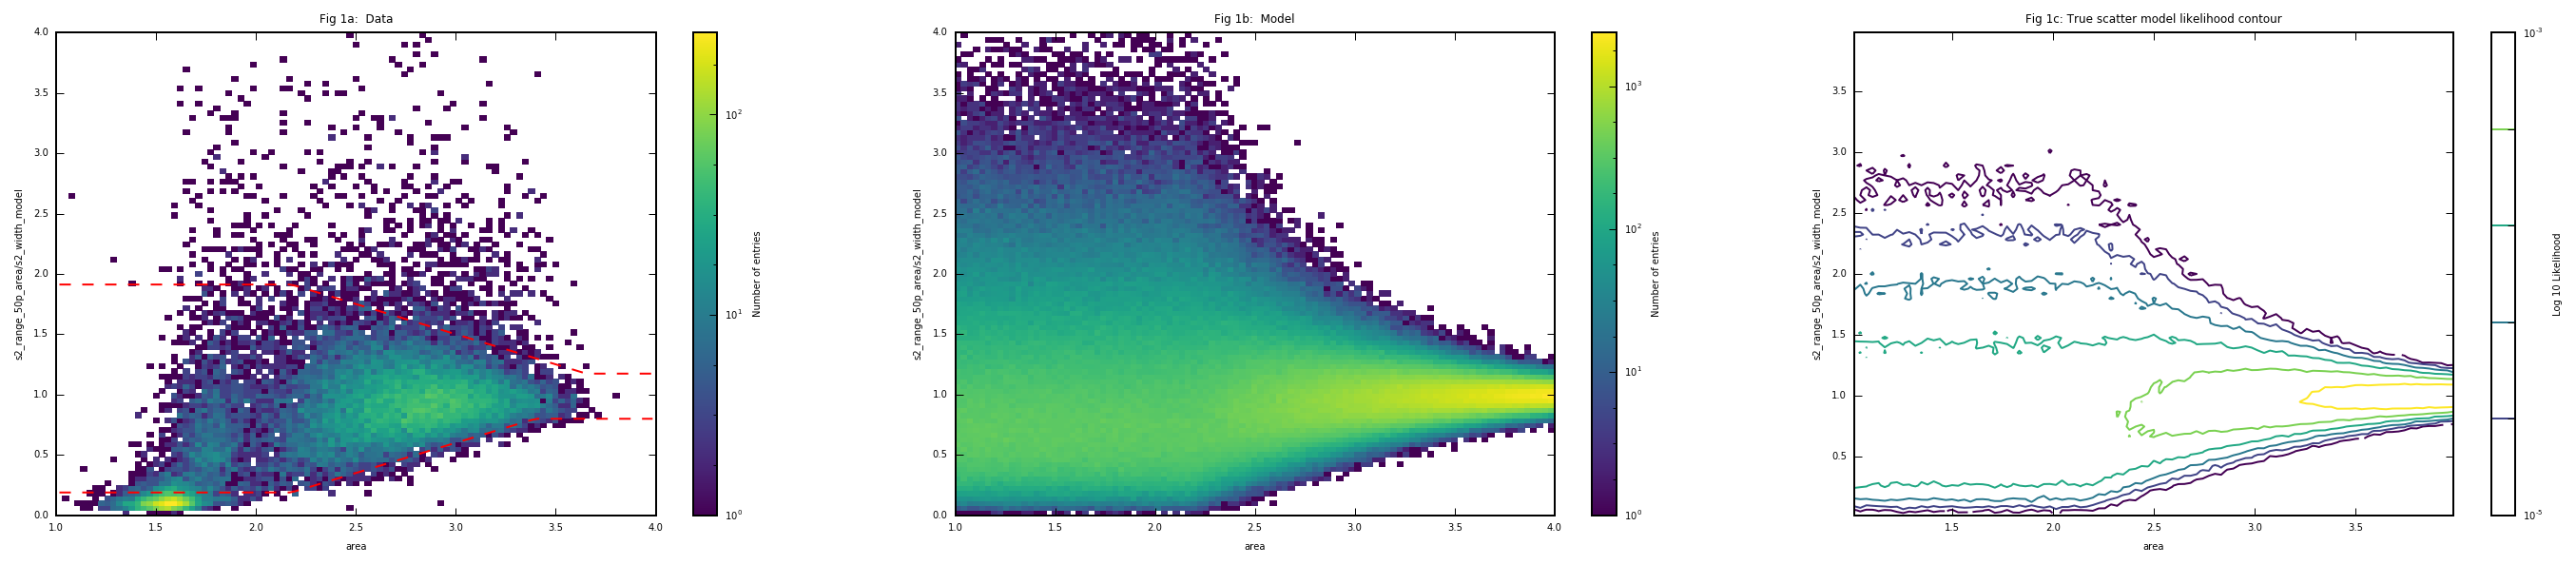

In [6]:
plt.rcParams['figure.figsize'] = (24, 10)
fig = plt.figure()

peak_order = '1'
drift_time = 's2_' + peak_order + '_delay_is1'
s2_range_50p_area = 's2_' + peak_order + '_range_50p_area'
z = 's2_' + peak_order + '_z'
largest_other_s2 = 's2_' + peak_order + '_area'
isms = 's2_'+peak_order+'_isms'
width_ratio = 's2_' + peak_order + '_width_ratio'

unified_bins = (np.linspace(1.0,4.0,100), np.linspace(0,4.0,100))
df_ =  df_nt
##################--------- Plot Data ----------#####################    
with plotting2d(231):
    mh = Histdd(np.log10(getattr(df_, largest_other_s2)), getattr(df_, width_ratio),
                axis_names = ('area', 's2_range_50p_area/s2_width_model'),
                bins = unified_bins)
    s2 = mh.bin_centers(axis = 0)
    plt.plot(s2, s2w.relative_s2_width_bounds(10**s2,'low'),'r--')
    plt.plot(s2, s2w.relative_s2_width_bounds(10**s2,'high'),'r--') 
    
plt_config(title = 'Fig 1a:  Data')

##################---------mc check----------#####################      
ns = int(1e6)
area = np.random.uniform(1,4,ns)
q = np.random.uniform(0,1,ns)
width = chi2.isf(q, np.clip(10**area, 150, np.inf)/23) / (np.clip(10**area, 150, np.inf)/23)

with plotting2d(232):
    mh = Histdd(area, width,
                axis_names = ('area', 's2_range_50p_area/s2_width_model'),
                bins = unified_bins)
    
plt_config(title = 'Fig 1b:  Model')

mh = Histdd(area, width,
            axis_names = ('area', 's2_range_50p_area/s2_width_model'),
            bins = unified_bins)

##################---------contour----------#####################    
ax = fig.add_subplot(233)
x, y, z = mh.bin_centers(axis = 0), mh.bin_centers(axis = 1), mh.histogram.T/ns
x, y = np.meshgrid(x, y)
plt.contour (x, y, z, levels = [10**n for n in [-5,-4.6,-4.2,-3.8,-3.4,-3]], norm = LogNorm(),cmap=plt.get_cmap('viridis'))

plt_config(title = 'Fig 1c: True scatter model likelihood contour',
           xlabel = 'area', ylabel = 's2_range_50p_area/s2_width_model',colorbar = 'Log 10 Likelihood', sci = False)
    
    
plt.show()

__C)__  Extract single electron distibution in area-width parameter space

- Histogram area and width of roughly selected single electron peaks
- Fit area and width histogram with Gauss and Chi2 respectivly
- Generate the 2d distribution by randomly drawing from the 2d distribution function
- And here we plot the contour just to check if it fit the data

_But note, here we select single electron peaks from the second largest peak in the event as samples. We did this in order to be consistant with the later part of the analysis. Thus we would expect the fit result being larger then true single electron's area and width_

area pdf gauss mean:38.09, simga:6.24
width pdf chi2 degree of freedom:23, horizontal expension:0.11


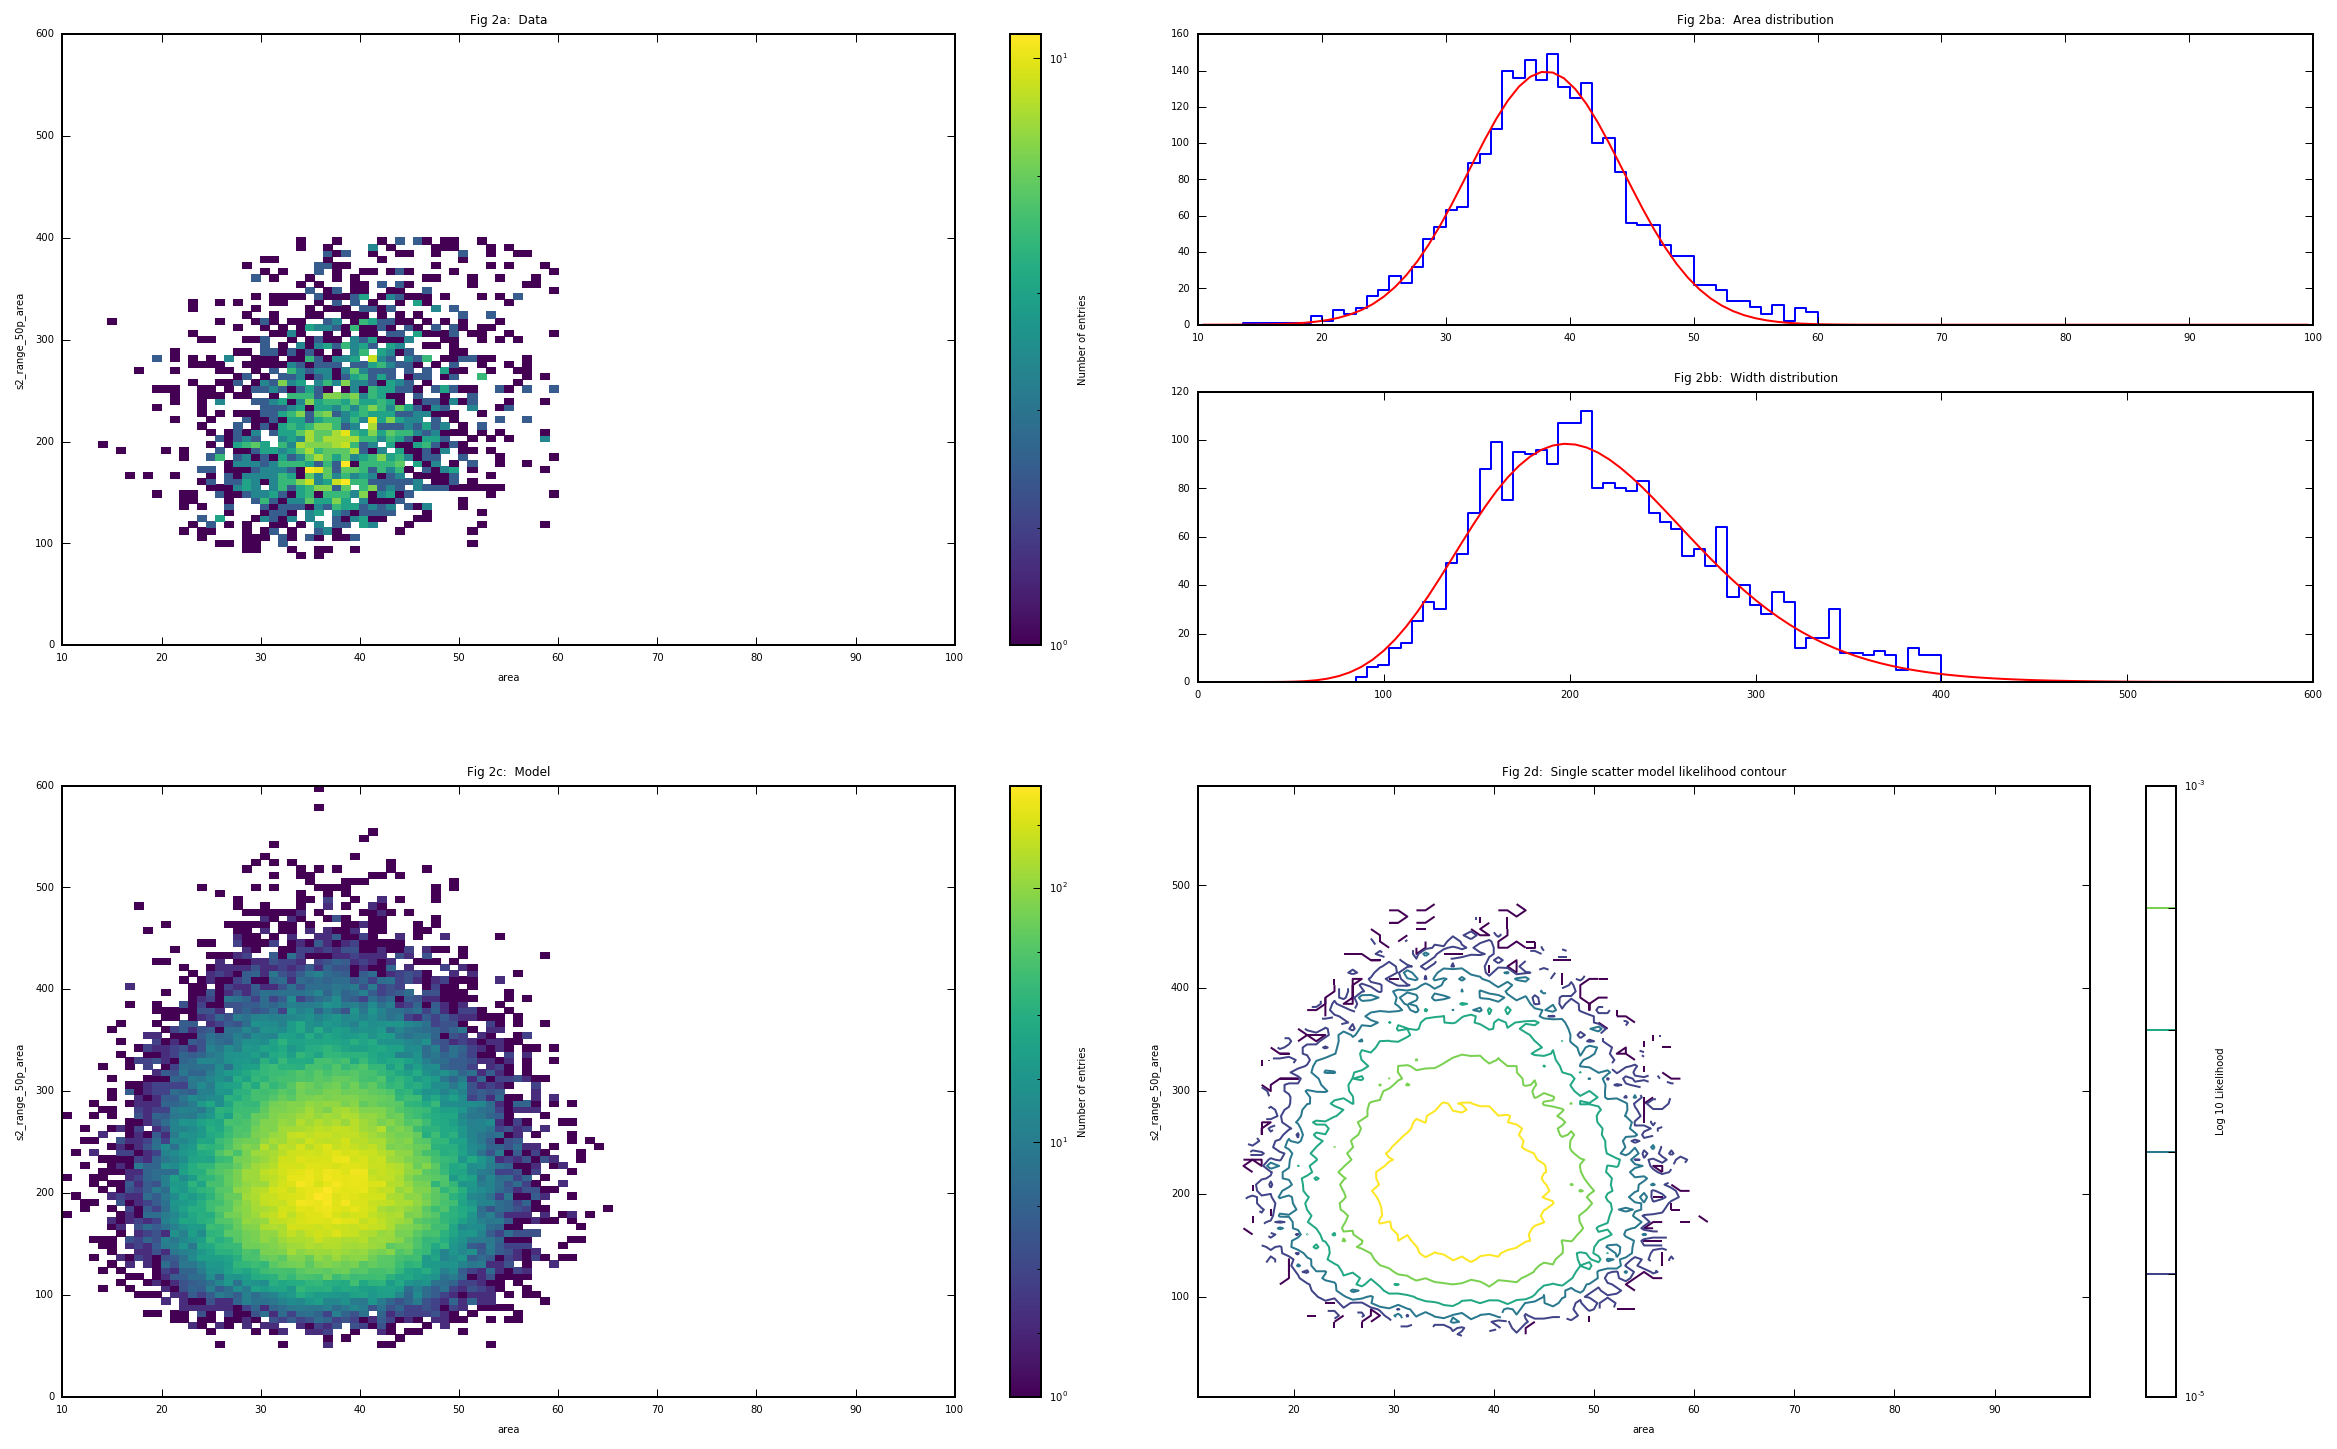

In [7]:
plt.rcParams['figure.figsize'] = (24, 10)
fig = plt.figure()

peak_order = '1'
drift_time = 's2_' + peak_order + '_delay_is1'
drift_time_2 = 's2_' + peak_order + '_delay_is2' 
s2_area_fraction_top = 's2_' + peak_order + '_area_fraction_top'
s2_range_50p_area = 's2_' + peak_order + '_range_50p_area'
x = 's2_' + peak_order + '_x'
y = 's2_' + peak_order + '_y'
z = 's2_' + peak_order + '_z'
largest_other_s2 = 's2_' + peak_order + '_area'
cs2 = 's2_' + peak_order + '_corrected_area'
isms = 's2_'+peak_order+'_isms'
width_ratio = 's2_' + peak_order + '_width_ratio'

##################--------- Plot Data ----------#####################    
sel_single = lambda df: df[(getattr(df, largest_other_s2) < 60) & (getattr(df, s2_range_50p_area) < 400)]

df_ = sel_single(df_rn)
#df_ = pd.concat([sel_single(df_nt),sel_single(df_rn)])
with plotting2d(231):
    mh = Histdd((getattr(df_, largest_other_s2)), getattr(df_, s2_range_50p_area),
                axis_names = ('area', 's2_range_50p_area'),
                bins = (np.linspace(10,100,100),np.linspace(0,600,100)))
plt_config(title = 'Fig 2a:  Data')

##################--------- Fits ----------#####################    
with plotting1d(432):
    ph = mh.project(axis = 0)
def gaussian(x, amp_a, mu, sigma):
    from numpy import sqrt, square
    return amp_a * np.exp(-(x-mu)**2/(2*sigma**2))/((2*np.pi)**0.5*sigma)
result_g = curve_fit(gaussian, ph.bin_centers, ph.histogram, p0 = [600,30,20])[0]
plt.plot(ph.bin_centers, gaussian(ph.bin_centers, *result_g),'r-')
plt_config(title = 'Fig 2ba:  Area distribution')
print ('area pdf gauss mean:%.2f, simga:%.2f' % (result_g[1],result_g[2]))

with plotting1d(435):
    ph = mh.project(axis = 1)
    plt_config(title = 'Fig 2bb:  Width distribution')
def my_chi2(x, k, mul,n):
    from scipy.stats import chi2
    return chi2.pdf(x*mul,k)*n*mul
result_c = curve_fit(my_chi2, ph.bin_centers[:66], ph.histogram[:66], p0 = [25,0.115,35e3])[0]
plt.plot(ph.bin_centers, my_chi2(ph.bin_centers, *result_c),'r-')
print ('width pdf chi2 degree of freedom:%d, horizontal expension:%.2f' % (result_c[0],result_c[1]))
    
##################---------mc check----------#####################    
ns = int(1e5)
area = np.random.normal(36.90057254,6.62448516,ns)
q = np.random.uniform(0,1,ns)
width = chi2.isf(q, 25) / 0.11372838

with plotting2d(234):
    global mh
    mh = Histdd(area, width,
                axis_names = ('area', 's2_range_50p_area'),
                bins = (np.linspace(10,100,100),np.linspace(0,600,100)))
    
plt_config(title = 'Fig 2c:  Model')

##################---------contour----------#####################    
ax = fig.add_subplot(235)
x, y, z = mh.bin_centers(axis = 0), mh.bin_centers(axis = 1), mh.histogram.T/ns
x, y = np.meshgrid(x, y)
plt.contour (x, y, z, levels = [10**n for n in [-5,-4.6,-4.2,-3.8,-3.4,-3]], norm = LogNorm(),cmap=plt.get_cmap('viridis'))

plt_config(title = 'Fig 2d:  Single scatter model likelihood contour',
           xlabel = 'area', ylabel = 's2_range_50p_area',colorbar = 'Log 10 Likelihood', sci = False)

plt.tight_layout()
plt.show()

__D)__  Extract multiple electrons pile up in area-width parameter space as well

- By examine the multile electrons pile up (usually treat as junk in S2 area-width space) sum_waveforms, we found out that they are primarily the case that two seperate single electron peaks or even one of them is an s1 peak being grouped into one peak.

- Thus we can simplify the area ditribution as Gauss while the width distribution a expernatial distribution with a Fermi-Dirac coeffeciency which is bassically the time inverval ditribution between two peaks.

area pdf gauss mean:60.25, simga:12.52
width pdf Fermi-Dirac Exp lamda:1.21E-03, threshold:906.84, rolloff:0.014187


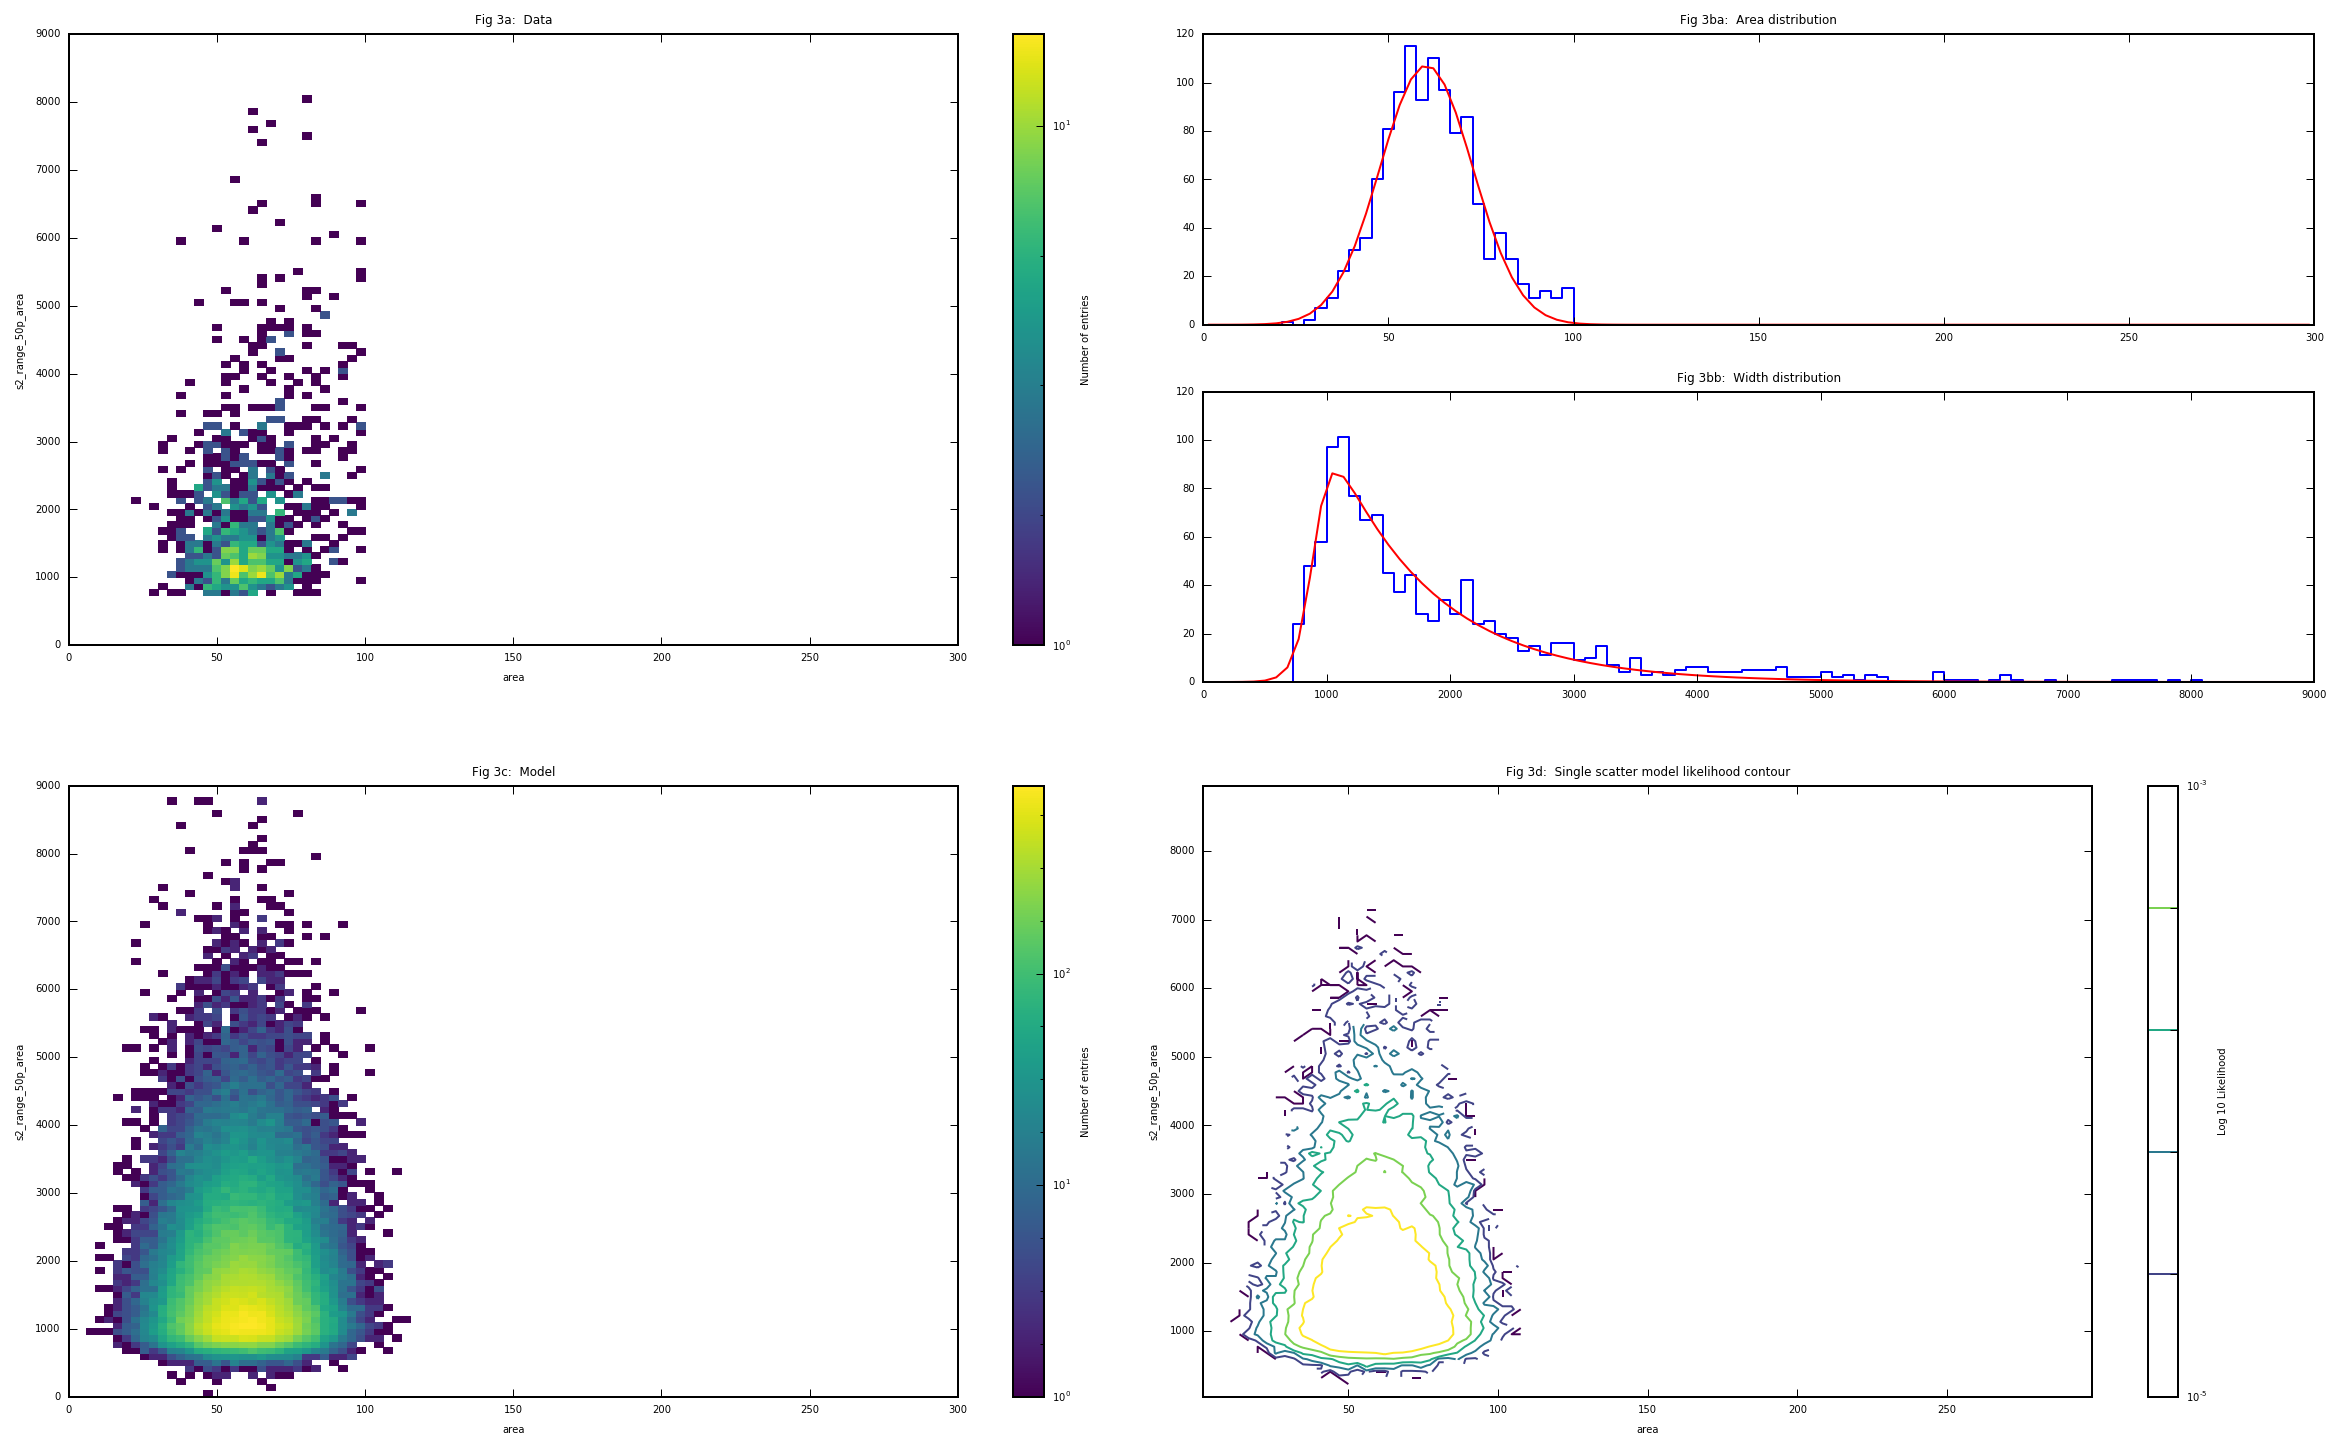

In [8]:
plt.rcParams['figure.figsize'] = (24, 10)
fig = plt.figure()

sel_junk = lambda df: df[(getattr(df, largest_other_s2) < 100) &
                         (getattr(df, s2_range_50p_area) < 30*300) &
                         (getattr(df, s2_range_50p_area) > 30*25)
                      ]
df_ = sel_junk(df_rn)
#df_ = pd.concat([sel_junk(df_rn),sel_junk(df_nt)])

##################--------- Plot Data ----------#####################    
with plotting2d(231):
    mh = Histdd((getattr(df_, largest_other_s2)), getattr(df_, s2_range_50p_area),
                axis_names = ('area', 's2_range_50p_area'),
                bins = (np.linspace(0,300,100),np.linspace(0,9000,100)))
plt_config(title = 'Fig 3a:  Data')

##################--------- Fits ----------#####################  
with plotting1d(432):
    ph = mh.project(axis = 0)
plt_config(title = 'Fig 3ba:  Area distribution')
def gaussian(x, amp_a, mu, sigma):
    from numpy import sqrt, square
    return amp_a * np.exp(-(x-mu)**2/(2*sigma**2))/((2*np.pi)**0.5*sigma)
result = curve_fit(gaussian, ph.bin_centers, ph.histogram, p0 = [100,75,20])[0]
plt.plot(ph.bin_centers, gaussian(ph.bin_centers, *result),'r-')
print ('area pdf gauss mean:%.2f, simga:%.2f' % (result[1],result[2]))
 
with plotting1d(435):
    global ph
    ph = mh.project(axis = 1)
plt_config(title = 'Fig 3bb:  Width distribution')
def fd_exp(x, lam, x0, rf, n):
    return n*lam*np.exp(-lam*x) * (1 / (np.exp((x0 - x) * rf) + 1))
result = curve_fit(fd_exp, ph.bin_centers, ph.histogram, p0 = [0.001,950,0.13,18e4])[0]
plt.plot(ph.bin_centers, fd_exp(ph.bin_centers, *result),'r-')
print ('width pdf Fermi-Dirac Exp lamda:%.2E, threshold:%.2f, rolloff:%2f' % (result[0],result[1],result[2]))
    
##################---------mc check----------#####################    
ns = int(1e5)
area = np.random.normal(59.73460212, 12.70892361,ns)
q = np.random.uniform(0,1,ns)
ph.histogram = fd_exp(ph.bin_centers, *result)
from scipy.interpolate import interp1d
ff = interp1d(ph.cumulative_density, ph.bin_centers)
width = ff(q)

with plotting2d(234):
    global mh
    mh = Histdd(area, width,
                axis_names = ('area', 's2_range_50p_area'),
                bins = (np.linspace(0,300,100),np.linspace(0,9000,100)))
    
plt_config(title = 'Fig 3c:  Model')

##################---------contour----------#####################    
ax = fig.add_subplot(235)
x, y, z = mh.bin_centers(axis = 0), mh.bin_centers(axis = 1), mh.histogram.T/ns
x, y = np.meshgrid(x, y)
plt.contour (x, y, z, levels = [10**n for n in [-5,-4.6,-4.2,-3.8,-3.4,-3]], norm = LogNorm(),cmap=plt.get_cmap('viridis'))

plt_config(title = 'Fig 3d:  Single scatter model likelihood contour',
           xlabel = 'area', ylabel = 's2_range_50p_area',colorbar = 'Log 10 Likelihood', sci = False)

plt.tight_layout()
plt.show()

__E)__ Now we can use the fit results to construct likelihood functions

First we write down the (almost) normalized distribution functions and define

    L_single_electron = gaussian(area) * chi2(width)
    
    L_pile_up = gaussian(area) * Fermi_Dirac_exponantial(width)
    
    L_true_scatter = f_distribution(width model ratio, dofn = area/gas_gain, dofd >> dofn)
    
Then we what to see what are our likelihood functions doing and how to use them to construct an optimized test for cutting multiple scatters.

In [9]:
# Write down all the likelihood function.
from numpy import sqrt, square
from scipy.stats import f, chi2

def normed_gaussian(x, mu, sigma):  
    return np.exp(-(x - mu) ** 2/(2 * sigma ** 2))/((2 * np.pi) ** 0.5 * sigma)

def normed_Fer_Dir_exp(x, lam, x0, rf):
    return lam / np.exp(-lam * x0) * np.exp(-lam * x) * (1 / (np.exp((x0 - x) * rf) + 1))

def normed_chi2(x, dof, mul):
    return chi2.pdf(x * mul, dof) * mul


##################################################################################

def se_likelihood(area, range_50p_area):
    mu, sigma = 36.34, 6.65
    k, mul = 25, 0.1137
    return normed_gaussian(area, mu, sigma)*normed_chi2(range_50p_area, k, mul)

def pileup_likelihood(area, range_50p_area):
    mu, sigma = 59.73, 12.71
    lam, x0, rf = 1.16e-03, 9.19e+02, 1.44e-02
    return normed_gaussian(area, mu, sigma)*normed_Fer_Dir_exp(range_50p_area, lam, x0, rf)

def scatter_likelihood(area, width_ratio, dofd = 1e4):
    gas_gain = 23
    dofn = np.clip(area, 150, np.inf) / gas_gain
    return (f.pdf(*np.vstack([width_ratio, dofn]), dfd = dofd))

##################################################################################

def conbined_log_likelihood(area, range_50p_area, width_ratio):
    ans = (
           - 2 * np.log((0.5*se_likelihood(area, range_50p_area) + 0.5*pileup_likelihood(area, range_50p_area))
                  /scatter_likelihood(area, width_ratio))
          )
    return ans

##################################################################################

def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

_But things got messy from here, the flow chart below might help clear the process up. Up at the very top is our goal, but to get there we need every steps follows_

 - Before we try to combine multiple peaks, we would ask ourselves 'how many peaks is optimal'. And what can we do to optimize it, when even optimizing the test for just one peak, we would run into two problems:
     - The single scatter likelihood actually have a free parameter (the relative ratio between single electron and pile-ups) this makes our null hypothesis not a simple hypothesis, instead, is a composite one. So 
         - What happens if we change the recipe of our test function? (By changing the ratio between single electron and multi-electron-pile-ups.)
         - What happens if the composition of those two changes from dataset to dataset(very likely to happen for different source strength and different energy deposition).  
             - To find out those effects, the strategy we adopted here is to see how __different tests__ work (different coefficients when adding single electron and pile up likelihood) __under different inputs__ (randomly generated peaks using different total probability distribution.)

     - The two (SS, MS) test statistics are not built in the same phase space. And this reflects in log likelihood ratio test as the deviation in MS LL is much smaller than deviation in SS LL.
         - Then the question is that should we scale up MS likelihood, or scaling is not necessary as we effectively scale the likelihood functions when reasonalbely change cutoff in Log likelihood space. (_it ramains an open question for me_)


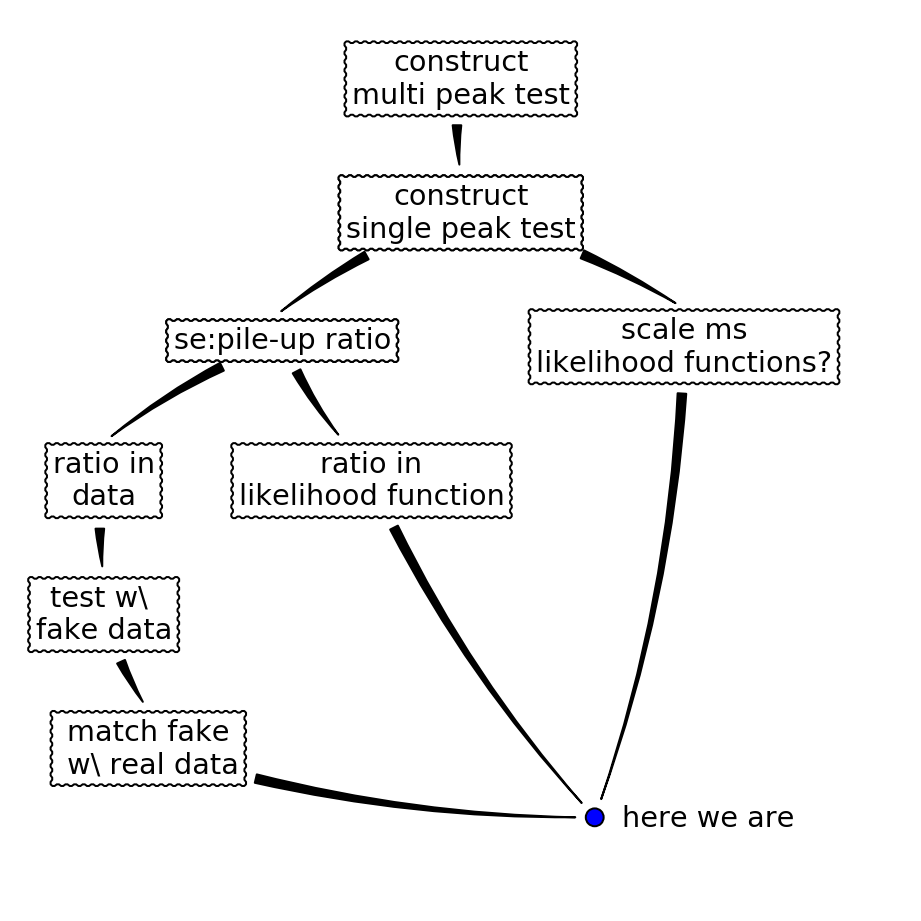

In [10]:
plt.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
import matplotlib.patches as mpatch

spacing = 1.2
fontsize = 0.2 * 72
ax = fig.add_subplot(111)
p = mpatch.Circle((0.65, 0.1), 0.01)
opts = dict(ha="center", size=fontsize, transform=fig.transFigure,
            bbox=dict(boxstyle='roundtooth', fc="w", ec="k"),
            arrowprops=dict(arrowstyle='wedge', patchB=p, shrinkA=5, shrinkB=5, fc="k", ec="k", connectionstyle="arc3,rad=0.08"))
optsr = dict(ha="center", size=fontsize, transform=fig.transFigure,
            bbox=dict(boxstyle='roundtooth', fc="w", ec="k"),
            arrowprops=dict(arrowstyle='wedge', patchB=p, shrinkA=5, shrinkB=5, fc="k", ec="k", connectionstyle="arc3,rad=-0.08"))


ax.add_patch(p)
plt.annotate('construct\nmulti peak test',(0.5,0.82),(0.5, 0.9), **opts)
plt.annotate('construct\nsingle peak test',(0.29,0.66),(0.5, 0.75), **opts)
plt.annotate('construct\nsingle peak test',(0.75,0.67),(0.5, 0.75), **optsr)
plt.annotate('se:pile-up ratio',(0.1,0.52),(0.3, 0.625), **opts)
plt.annotate('se:pile-up ratio',(0.37,0.52),(0.3, 0.625), **opts)
plt.annotate('ratio in\ndata',(0.1,0.37),(0.1, 0.45), **opts)
plt.annotate('ratio in\nlikelihood function',(0.65,0.1),(0.4, 0.45), **opts)
plt.annotate('test w\ \nfake data',(0.15,0.22),(0.1, 0.3), **opts)
plt.annotate('match fake\n w\ real data',(0.65,0.1),(0.15, 0.15), **opts)
plt.annotate('scale ms\nlikelihood functions?',(0.65,0.1),(0.75, 0.60), **optsr)
plt.annotate('here we are',(0.68,0.09),size=fontsize)
ax.set_axis_off()
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
plt.show()


__F)__ We start with generating some fake data according to the modelled distribution we got earlier in the note and see if we can match them to data

The reason we don't use pure data to examine the efficiency of different tests is because we couldn't get pure multiple scatter samples unless using simulation, also because pure data won't give us various composition of single electron and multi-electron pileup. While by using fake data we can manually tune the composition of single-electrons and multi-electron-pile-ups, and we can also tune it to match data.

However there is a small problem that we don't have a 'Z' distribution which is relavent in production of width:model ratio. In this work we just use uniform distribution, and it turns out fine.

In [11]:
#########################Here we generate mc data to check rejection power##################
ns = int(1e5)
df_mc_ms = pd.DataFrame()
df_mc_ms['area'] = np.random.uniform(80,2000,ns)
q = np.random.uniform(0,1,ns)
df_mc_ms['width_ratio'] = chi2.isf(q, np.clip(df_mc_ms['area'].values, 150, np.inf)/23) / (np.clip(df_mc_ms['area'].values, 150, np.inf)/23)
z = np.random.uniform(-90,-10,ns)
df_mc_ms['width'] = df_mc_ms['width_ratio'].values * s2w.s2_width_model(z)

ns = int(1e5)
df_mc_pu = pd.DataFrame()
df_mc_pu['area'] = np.random.normal(59.82, 12.74,ns)
q = np.random.uniform(0,1,ns)
ph = Hist1d(np.zeros(10),bins = np.linspace(0,9000,500))
ph.histogram = normed_Fer_Dir_exp(ph.bin_centers, 1.16e-03, 9.19e+02, 1.44e-02)
from scipy.interpolate import interp1d
ff = interp1d(ph.cumulative_density, ph.bin_centers)
df_mc_pu['width'] = ff(q)
z = np.random.uniform(-150,-0,ns)
df_mc_pu['width_ratio'] = df_mc_pu['width'].values / s2w.s2_width_model(z)

ns = int(1e5)
df_mc_se = pd.DataFrame()
df_mc_se['area'] = np.random.normal(38.32,6.35,ns)
q = np.random.uniform(0,1,ns)
df_mc_se['width'] = chi2.isf(q, 23) / 0.11
z = np.random.uniform(-150,0,ns)
df_mc_se['width_ratio'] = df_mc_se['width'].values / s2w.s2_width_model(z)

In the following figures, we compare real data with our fake ones. For the real data, we take Rn220 data as SS, while for MS we used a small trick, that only taking those peak area larger than 80pe from neutron generator, AmBe and fake data for comparison.

And when we make our se:pileup ratio to be 65%:35% we got a good match with data. But we do notice that there is a small population not showing up in fake data as shown in figure 4bc, and we ignore them for now.

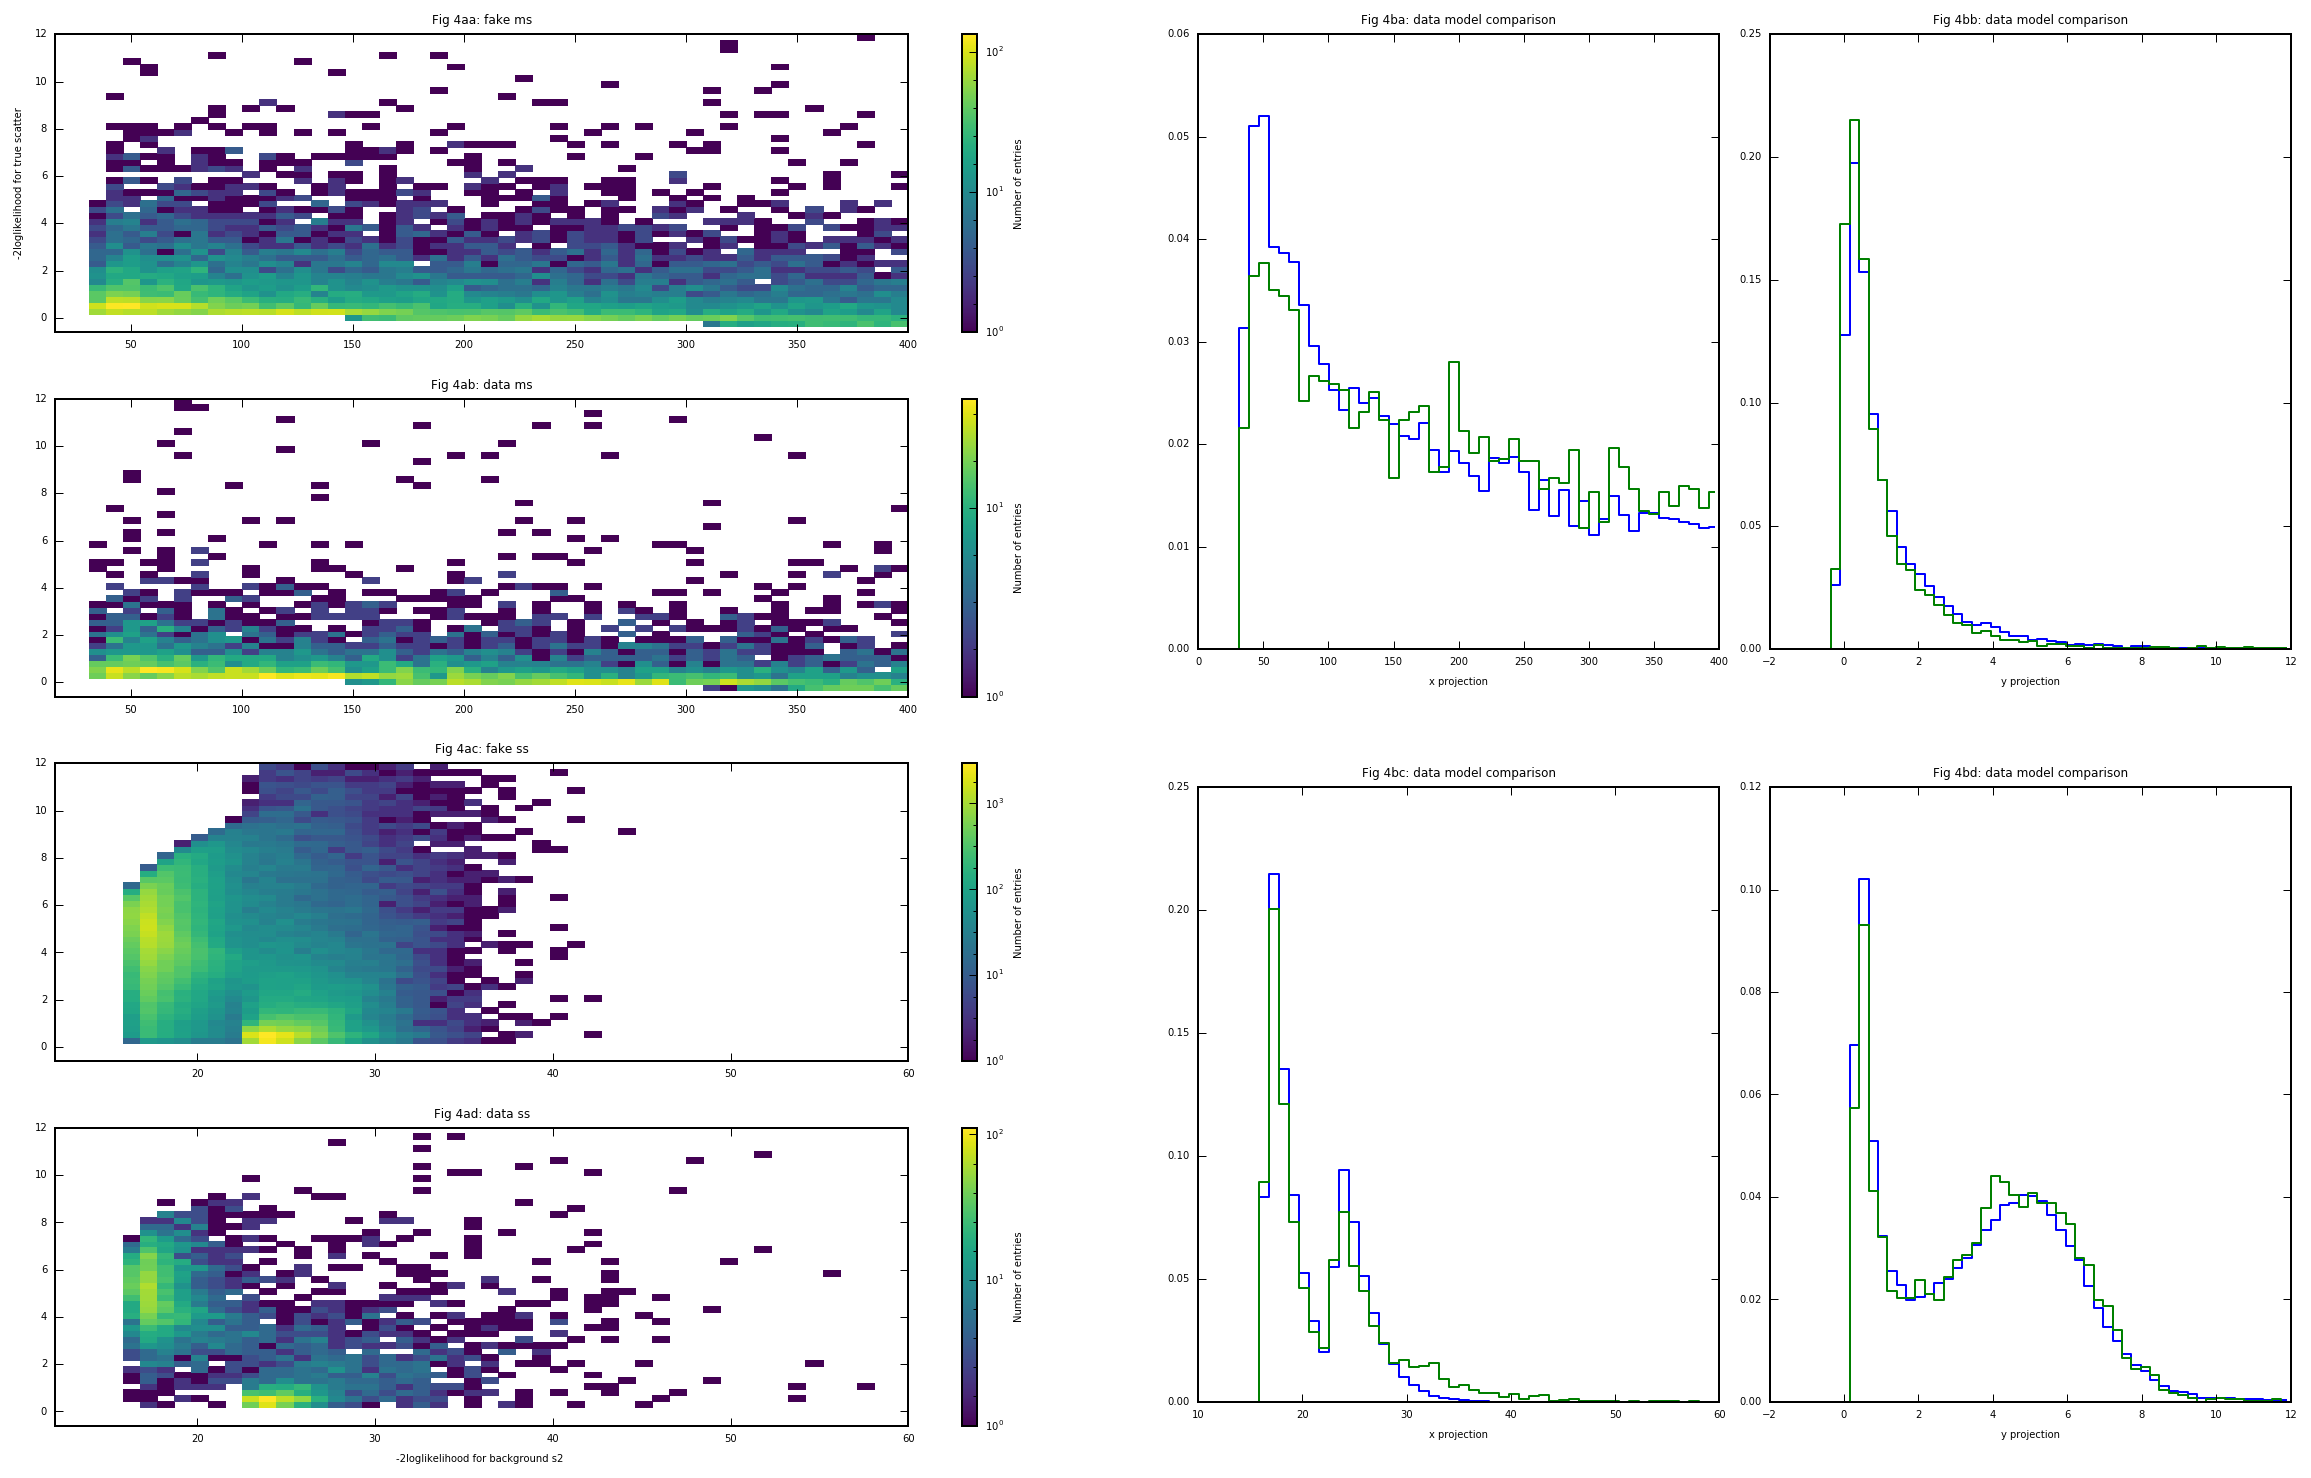

In [12]:
#########################Here we chech if mc data match real data##################
plt.rcParams['figure.figsize'] = (16, 15)
fig = plt.figure()

llh = [se_likelihood, pileup_likelihood, scatter_likelihood]

emu, kmu = 0.65, 0.65
loglx, logly = 'loglx', 'logly'
area, width, width_ratio = 'area', 'width', 'width_ratio'
unified_bins_ms = (np.linspace(16,400,51),np.linspace(-0.6,12,51))
unified_bins_ss = (np.linspace(12,60,51),np.linspace(-0.6,12,51))

def addll(df, loglx, logly, kmu):
    if loglx != None:
        df[loglx] = - 2 * np.log(kmu*llh[0](getattr(df, area),getattr(df, width))
                                 +(1-kmu)*llh[1](getattr(df, area),getattr(df, width))
                                )
    if logly != None:
        df[logly] = - 2 * np.log(llh[2](getattr(df, area),getattr(df, width_ratio)))
    return df

###########################Plot MS MC##############################
df_m = df_mc_ms
df_m = df_m[getattr(df_m, area) > 100]
df_m = addll(df_m, loglx, logly, kmu)
with plotting2d(621):
    mh = Histdd(getattr(df_m, loglx), getattr(df_m, logly),
                axis_names = ('', '-2loglikelihood for true scatter'),
                bins = unified_bins_ms)
plt_config(title = 'Fig 4aa: fake ms')

with plotting1d(343):
    ph = mh.project(axis = 0)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
with plotting1d(344):
    ph = mh.project(axis = 1)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
    
###########################Plot SS MC with emu composition##############################
df_s = pd.concat([df_mc_se.sample(frac = emu), df_mc_pu.sample(frac =(1-emu))])
df_s = addll(df_s, loglx, logly, kmu)
with plotting2d(625):
    mh = Histdd(getattr(df_s, loglx), getattr(df_s, logly), 
                #axis_names = ('background s2 -loglikelihood', 'true scatter -loglikelihood'),
                bins = unified_bins_ss)
plt_config(title = 'Fig 4ac: fake ss')

with plotting1d(347):
    ph = mh.project(axis = 0)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
with plotting1d(348):
    ph = mh.project(axis = 1)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)

##########################back to real data##########################
peak_order = '1'
width = 's2_' + peak_order + '_range_50p_area'
area = 's2_' + peak_order + '_area'
width_ratio = 's2_' + peak_order + '_width_ratio'
loglx = 's2_' + peak_order + '_loglikelihood_x'
logly = 's2_' + peak_order + '_loglikelihood_y'

###########################Plot MS data##############################
df_m = df_nt
df_m = df_m[getattr(df_m, area) > 100]
df_m = addll(df_m, loglx, logly, kmu)
with plotting2d(623):
    mh = Histdd(getattr(df_m, loglx), getattr(df_m, logly),
                #axis_names = ('background s2 -loglikelihood', 'true scatter -loglikelihood'),
                bins = unified_bins_ms)
plt_config(title = 'Fig 4ab: data ms')

with plotting1d(343):
    ph = mh.project(axis = 0)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
plt_config(title = 'Fig 4ba: data model comparison', xlabel = 'x projection')

with plotting1d(344):
    ph = mh.project(axis = 1)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
plt_config(title = 'Fig 4bb: data model comparison', xlabel = 'y projection')

###########################Plot SS data##############################
df_s = df_rn
df_s = addll(df_s, loglx, logly, kmu)
with plotting2d(627):
    mh = Histdd(getattr(df_s, loglx), getattr(df_s, logly), 
                axis_names = ('-2loglikelihood for background s2 ', ''),
                bins = unified_bins_ss)
plt_config(title = 'Fig 4ad: data ss')
    
with plotting1d(347):
    ph = mh.project(axis = 0)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
plt_config(title = 'Fig 4bc: data model comparison', xlabel = 'x projection')

with plotting1d(348):
    ph = mh.project(axis = 1)
    ph = Hist1d.from_histogram(ph.normalized_histogram, bin_edges = ph.bin_edges)
plt_config(title = 'Fig 4bd: data model comparison', xlabel = 'y projection')

plt.tight_layout()
plt.show()

__G)__ It's now useful to just use fake data to answer the question of what happens to the test efficiency when we change the test as well as changing the data being tested. As we mentioned before, we use the common strategy of examining test efficiency we plot first type error against second type error as we scan throught cutoff value, (we change them to acceptance and rejection accordingly) 

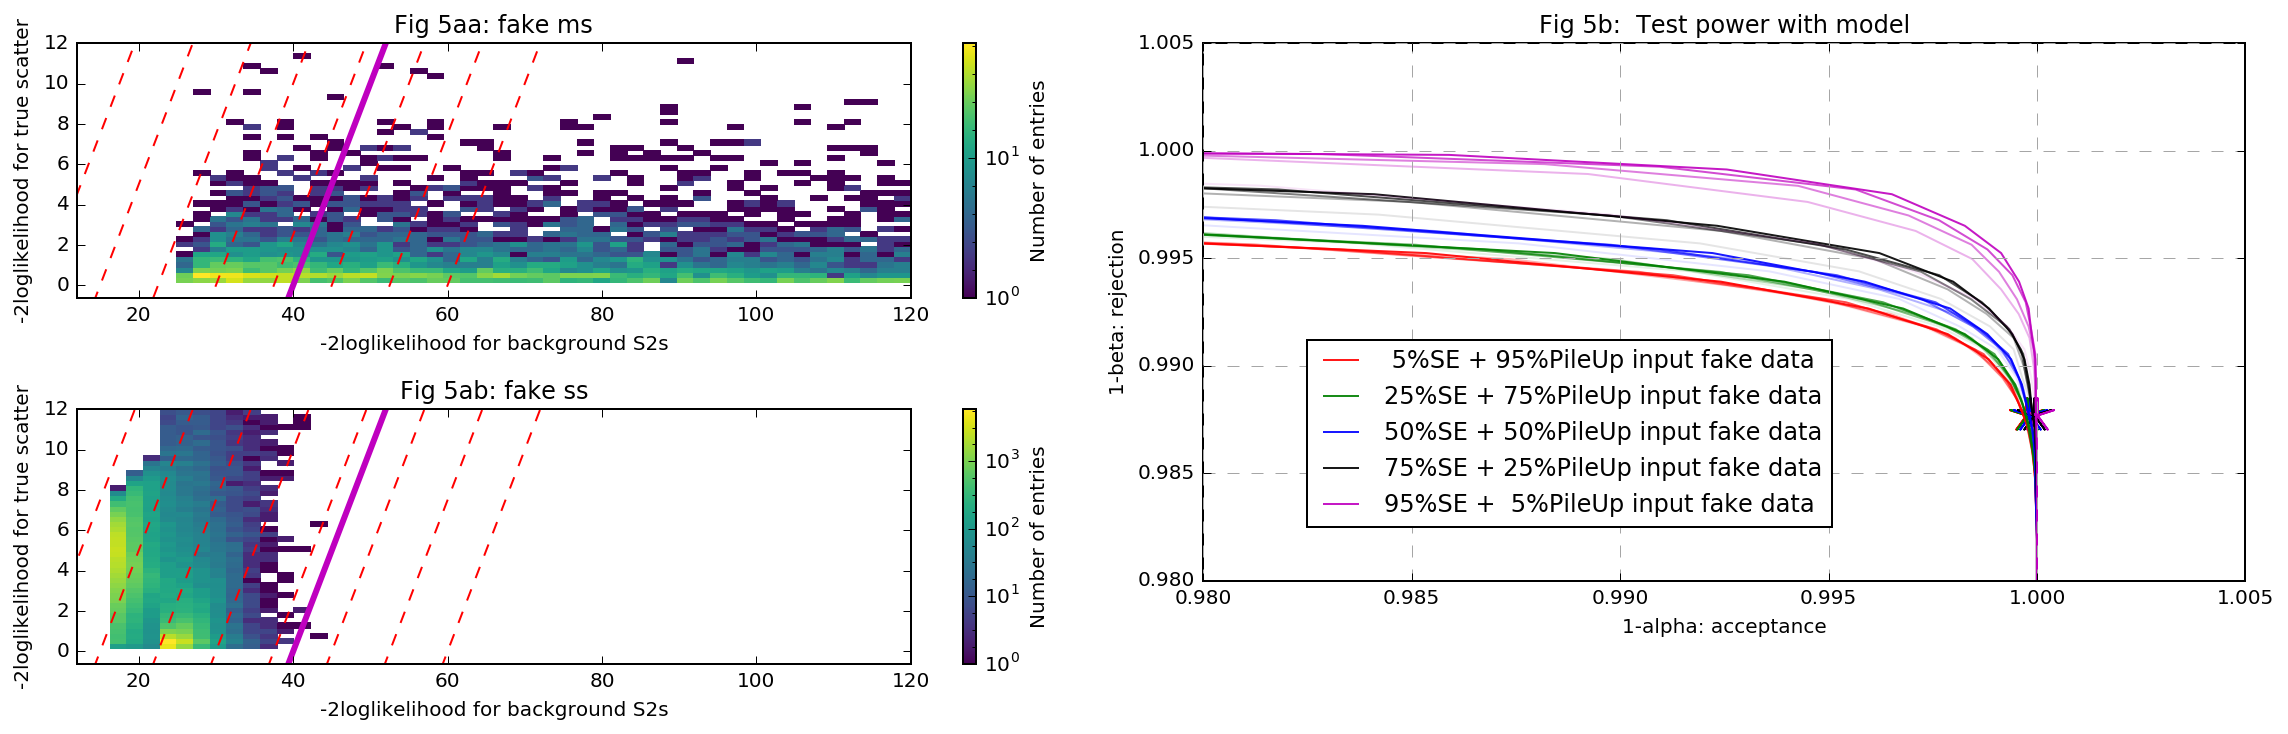

In [13]:
plt.rcParams['figure.figsize'] = (16, 15)
plt.rcParams['font.size'] = 10

fig = plt.figure()

llh = [se_likelihood, pileup_likelihood, scatter_likelihood]

cutoff = -40
x = np.linspace(0, 400, 101)
emu, kmu = 0.65, 0.65
loglx, logly = 'loglx', 'logly'
area, width, width_ratio = 'area', 'width', 'width_ratio'

def addll(df, loglx, logly, kmu):
    if loglx != None:
        df[loglx] = - 2 * np.log(kmu*llh[0](getattr(df, area),getattr(df, width))
                                 +(1-kmu)*llh[1](getattr(df, area),getattr(df, width))
                                )
    if logly != None:
        df[logly] = - 2 * np.log(llh[2](getattr(df, area),getattr(df, width_ratio)))
    return df

def plot_demolines():
    for a in np.linspace(-60,0,9):
        plt.plot(x, x + a, 'r--', lw = 1.0)
    a = cutoff
    plt.plot(x, x + a, 'm-', lw = 3.0)
unified_bins = (np.linspace(12,120,51),np.linspace(-0.6,12,51))

###########################Plot MS MC##############################
df_m = df_mc_ms[getattr(df_mc_ms, area) > 80]
df_m = addll(df_m, loglx, logly, kmu)
with plotting2d(621):
    mh = Histdd(getattr(df_m, loglx), getattr(df_m, logly),
                axis_names = ('-2loglikelihood for background S2s', '-2loglikelihood for true scatter'),
                bins = unified_bins)
plt_config(title = 'Fig 5aa: fake ms')
plot_demolines()
###########################Plot SS MC with emu composition##############################
df_s = pd.concat([df_mc_se.sample(frac = emu), df_mc_pu.sample(frac = 1-emu)])
df_s = addll(df_s, loglx, logly, kmu)
with plotting2d(623):
    mh = Histdd(getattr(df_s, loglx), getattr(df_s, logly), 
                axis_names = ('-2loglikelihood for background S2s', '-2loglikelihood for true scatter'),
                bins = unified_bins)
plt_config(title = 'Fig 5ab: fake ss')
plot_demolines()
###########################Plot cut power curve with emu composition & kmu test##############################
ax = fig.add_subplot(322)
c = ['r','g','b','k','m']

handles = []
plt.legend(['s2_1','Rn220 s2_1','s2_5'],loc = [0.5,0.5])
for k, emu in enumerate([0.05,0.25,0.5,0.75,0.95]):
    df_s = pd.concat([df_mc_se.sample(frac = emu), df_mc_pu.sample(frac = 1-emu)])
    for j, kmu in enumerate(np.linspace(0.1,0.9,5)):
        df_m = addll(df_m, loglx, None, kmu)
        df_s = addll(df_s, loglx, logly, kmu)
        alpha, beta = np.zeros(51), np.zeros(51)
        flag = True
        for i, a in enumerate(np.linspace(-60, 0, 51)):
            alpha[i] = len(df_s[getattr(df_s, logly) < a + getattr(df_s, loglx)])/len(df_s)
            beta[i] = len(df_m[getattr(df_m, logly) > a + getattr(df_m, loglx)])/len(df_m)
        line, = plt.plot(1 - alpha, 1 - beta, color = c[k], ls = '-', alpha = kmu, 
                         label = '%2d%%SE + %2d%%PileUp input fake data' %(emu*100, 100-emu*100))
        if j == 4: 
            handles.append(line)
            plt.scatter(1 - len(df_s[getattr(df_s, 'logly') < cutoff + getattr(df_s, 'loglx')])/len(df_s),
                        1 - len(df_m[getattr(df_m, 'logly') > cutoff + getattr(df_m, 'loglx')])/len(df_m),
                        s=300, c=c[k], marker=(5, 2))       
            
plt.legend(handles = handles, loc = [0.1,0.1])
        
plt_config(title = 'Fig 5b:  Test power with model',
           xlabel = '1-alpha: acceptance', ylabel = '1-beta: rejection',xbounds = [0.98,1.005], ybounds = [0.98,1.005])
plt.grid(b=True, which='both', color='0.65',linestyle='--')

plt.tight_layout()
plt.show()

In figure 5aa and 5ab, the cutoff value in likelihood ratio test turns into diagonal lines with different intercepts, and as we scan different intercepts we got the figure 5b, colors corresponding to different input composition and within each color we get slightly different result for different likelihood function for null hypothesis.

So farm we choose -40 intercept (cutoff = -40), the reason is that it's right before different color line split up, so that we could have as much rejection power before losing acceptance.

__H)__ Next question to answer is how many peaks should we use if we want to test multiple peaks. So we plot the test statistics namely log likelihood ratio using real Rn220 and neutron generator and AmBe data. And although we want as many peaks as possible, the 4th and 5th peaks start to deviate from the model we build, as in figure 6a4 and 6a5 there is a new population pops up. As a result we will use just 3 peaks for testing.

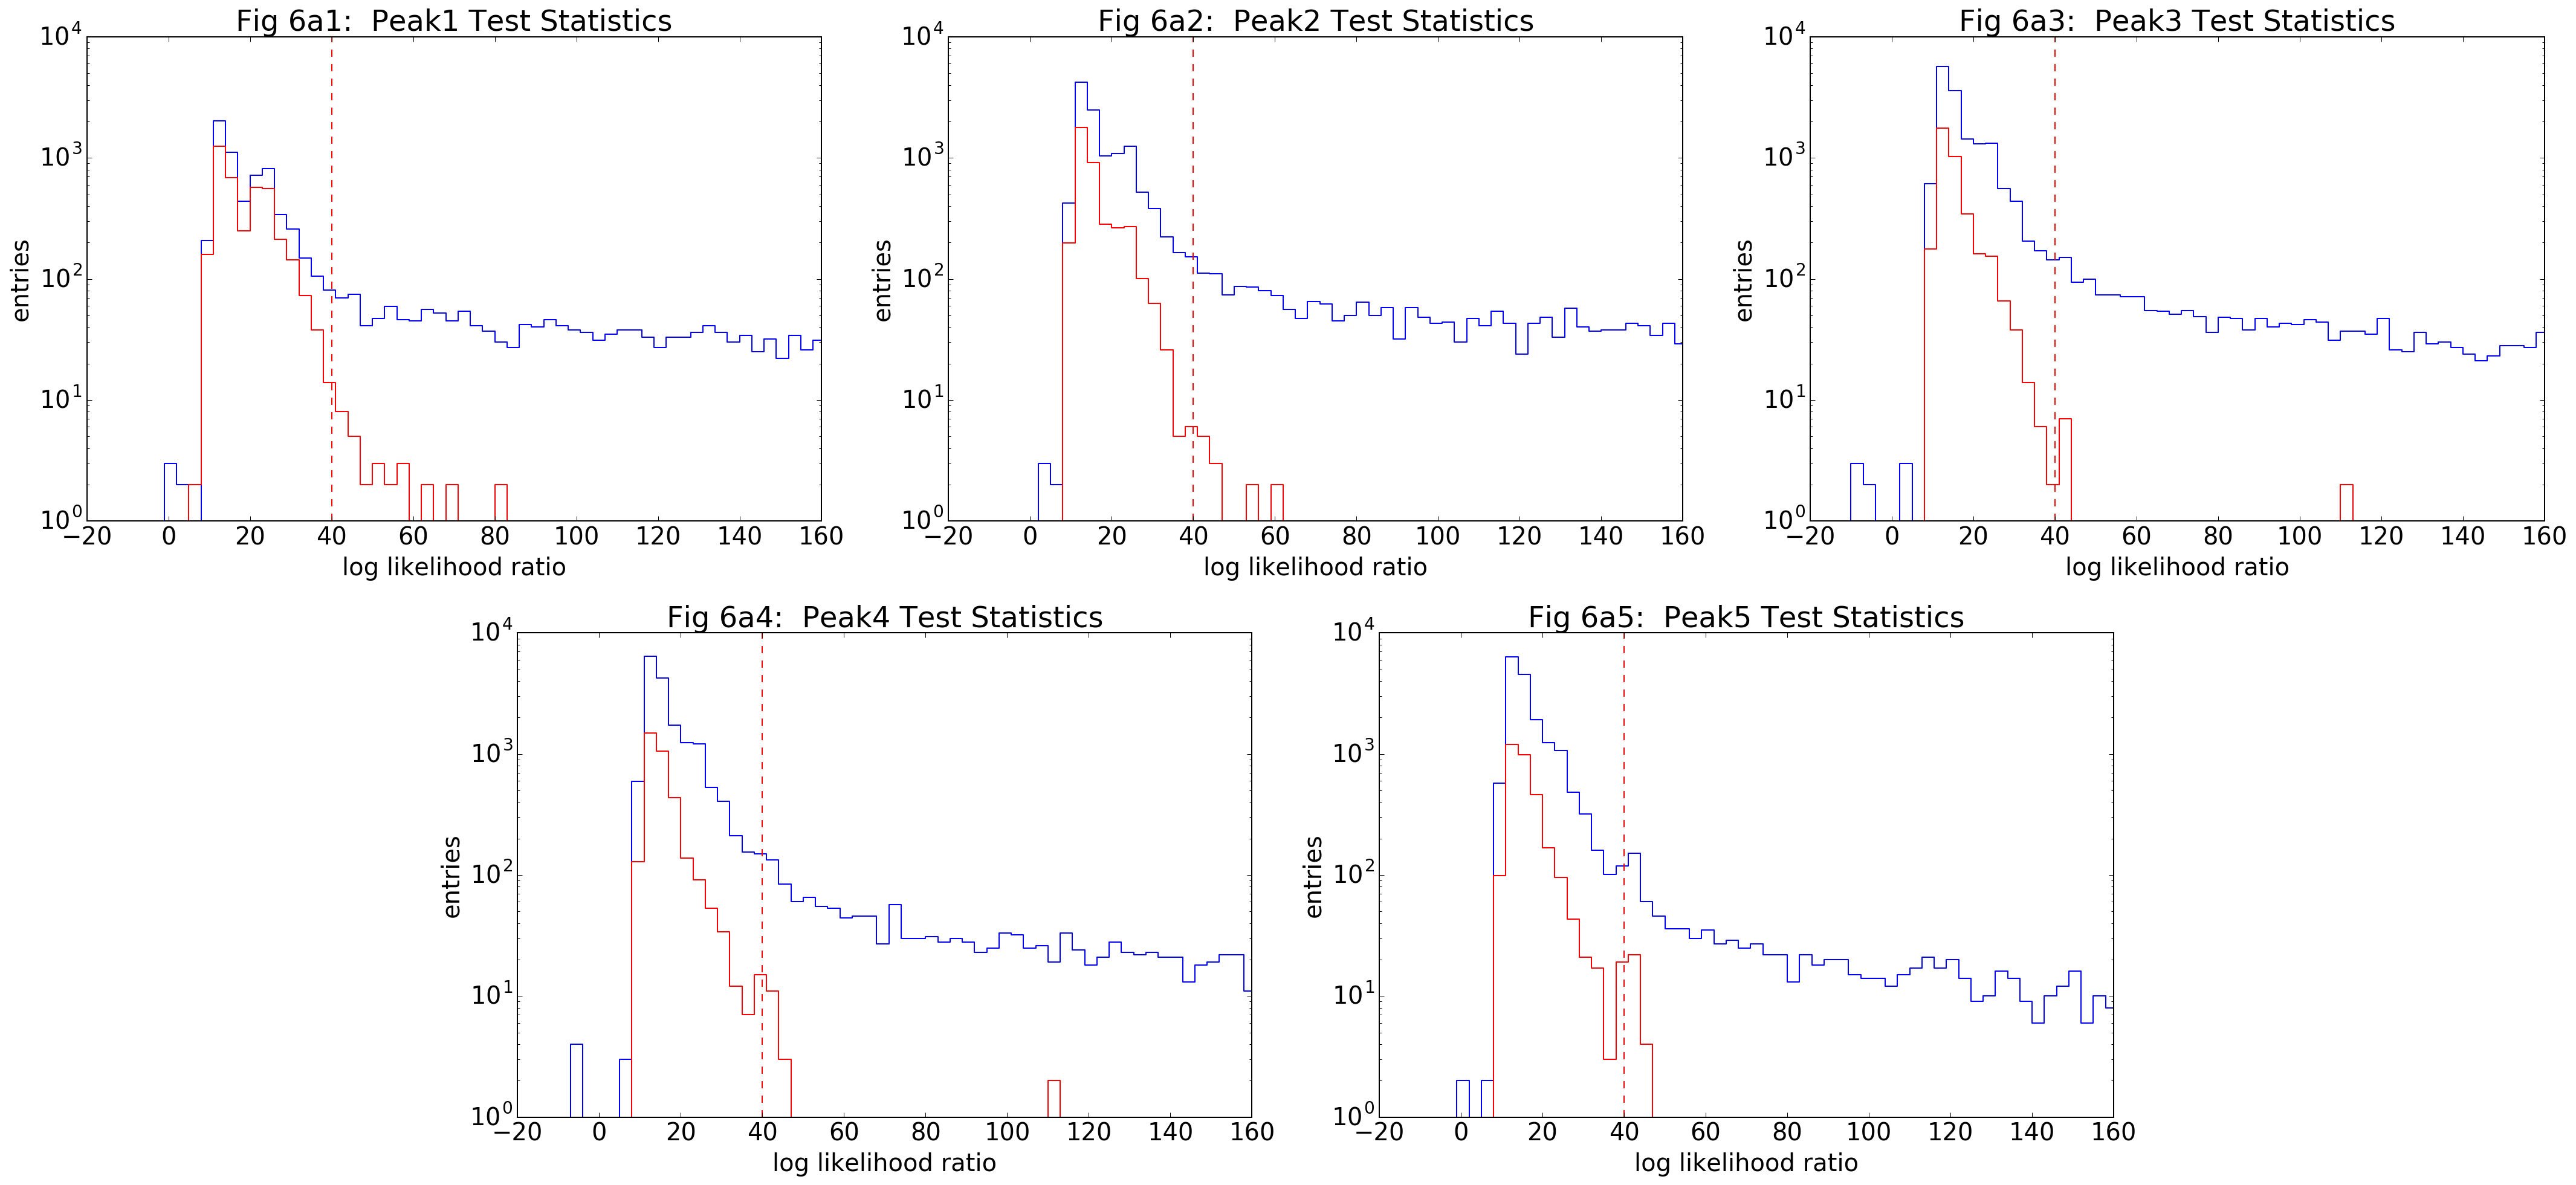

In [14]:
plt.rcParams['figure.figsize'] = (30, 14)
plt.rcParams['font.size'] = 20
fig = plt.figure()

logl = []
for i, peak_order in enumerate(['1', '2', '3', '4', '5']):
    width = 's2_' + peak_order + '_range_50p_area'
    area = 's2_' + peak_order + '_area'
    width_ratio = 's2_' + peak_order + '_width_ratio'
    logl.append('s2_' + peak_order + '_loglikelihood')

    df_nt[logl[-1]] = conbined_log_likelihood(getattr(df_nt, area), getattr(df_nt, width), getattr(df_nt, width_ratio))
    df_rn[logl[-1]] = conbined_log_likelihood(getattr(df_rn, area), getattr(df_rn, width), getattr(df_rn, width_ratio))

    #####################################################################
    if i < 3: ax = plt.subplot2grid((2, 6), (0, i*2), colspan=2)
    else: ax = plt.subplot2grid((2, 6), (1, i*2-5), colspan=2)

    _show_order = i

    df_ = df_nt
    ph = Hist1d(getattr(df_, logl[_show_order]), bins = 100, range =  [-100,200])
    ph.plot(color = 'b', ls = '-')

    df_ = df_rn 
    ph = Hist1d(getattr(df_, logl[_show_order]), bins = 100, range =  [-100,200])
    ph.plot(color = 'r', ls = '-')
    plt.yscale('log')
    plt_config(title = 'Fig 6a%d:  Peak%d Test Statistics' %(i+1,i+1), xbounds = [-20,160], ybounds = [0,1e4],
               xlabel = 'log likelihood ratio', ylabel = 'entries', sci = False)

    cutoff = 40
    plt.axvline(cutoff,color = 'r',ls = '--')

plt.tight_layout()
plt.show()

__I)__ Finally we got to the final test, we have following criteria for distinguishing SS and MS

    s2_i_ll_ratio = 
    - 2*log( (0.5*L_single_electron + 0.5*L_pile_ups) / L_true_scatter) 
    
    if (s2_1_ll_ratio < 40) and (s2_1_ll_ratio < 40) and (s2_3_ll_ratio < 40) it's a single scatter event.
    
    else it's a multiple scatter event.
    
And following we checked the test efficency of the this combined test.

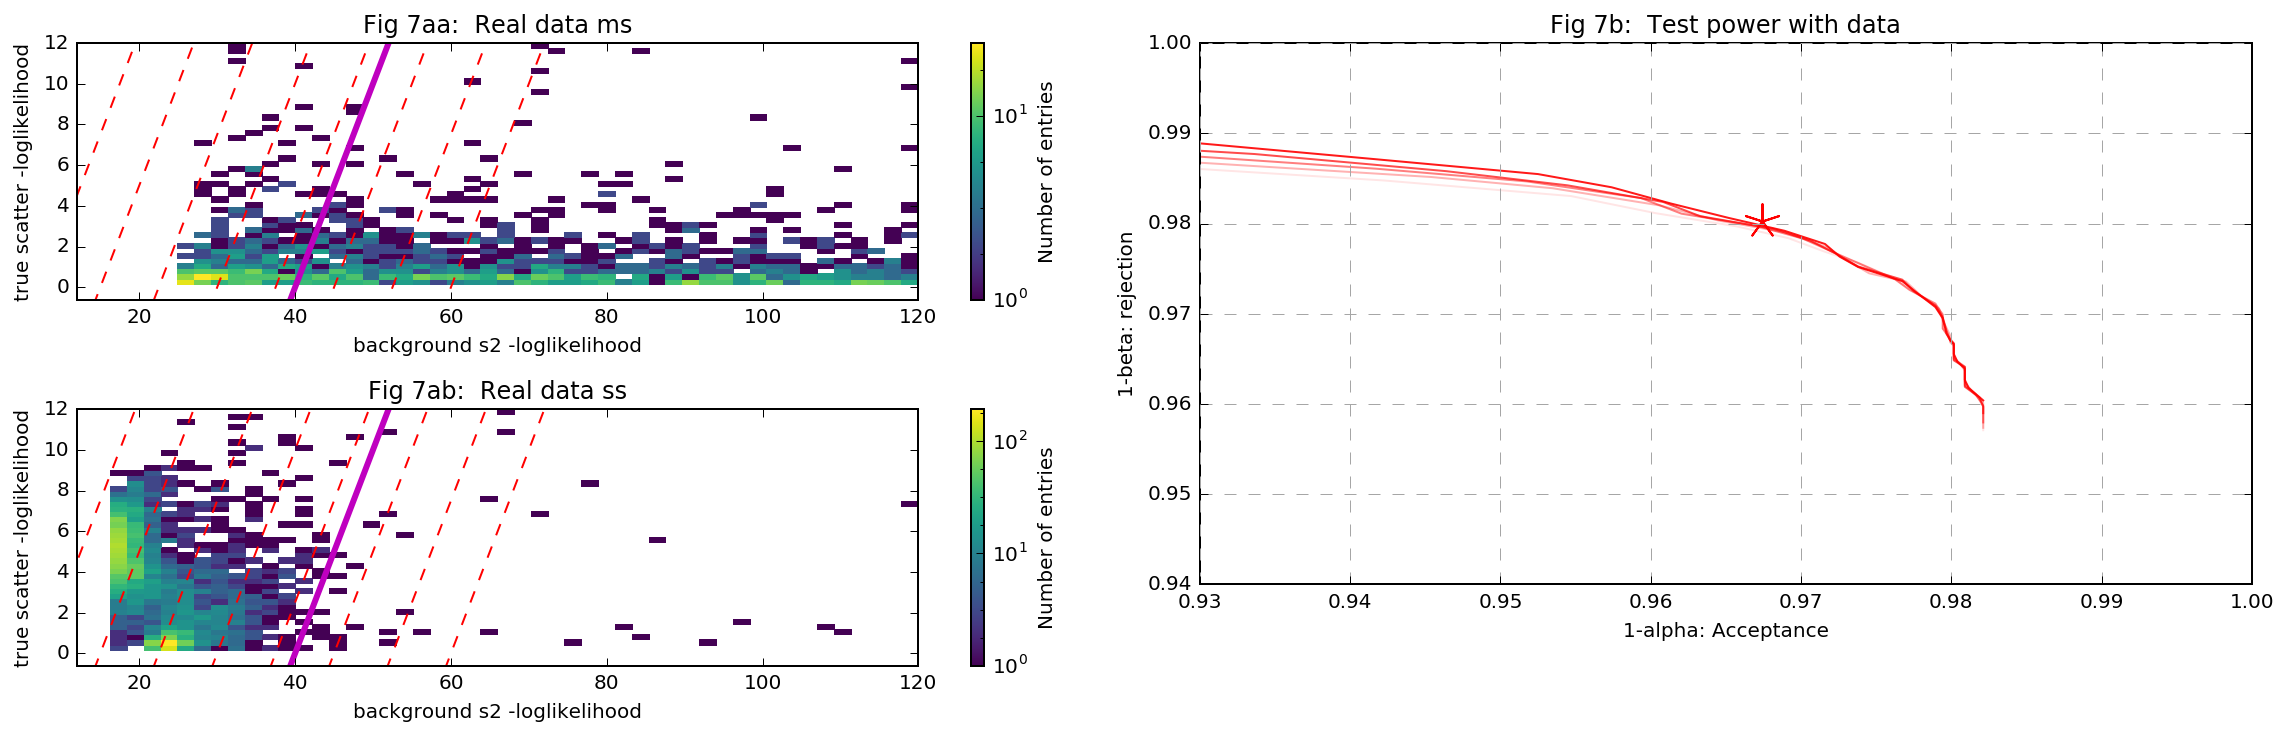

In [15]:
plt.rcParams['figure.figsize'] = (16, 15)
plt.rcParams['font.size'] = 10

fig = plt.figure()

llh = [se_likelihood, pileup_likelihood, scatter_likelihood]

cutoff = -40
x = np.linspace(0, 400, 101)
emu, kmu = 0.6, 0.5
loglx, logly = 'loglx', 'logly'
area, width, width_ratio = 'area', 'width', 'width_ratio'

def addll(df, loglx, logly, kmu):
    if loglx != None:
        df[loglx] = - 2 * np.log(kmu*llh[0](getattr(df, area),getattr(df, width))
                                 +(1-kmu)*llh[1](getattr(df, area),getattr(df, width))
                                )
    if logly != None:
        df[logly] = - 2 * np.log(llh[2](getattr(df, area),getattr(df, width_ratio)))
    return df

def plot_demolines():
    for a in np.linspace(-60,0,9):
        plt.plot(x, x + a, 'r--', lw = 1.0)
    a = cutoff
    plt.plot(x, x + a, 'm-', lw = 3.0)
    
c = ['r','g','b','k','m']
##########################back to real data##########################
area = 's2_1_area'
###########################Plot MS data##############################
df_m = df_nt[getattr(df_nt, area) > 80]

loglx, logly = [], []
for ix, peak_order in enumerate(['1','2','3','4','5']):
    width = 's2_' + peak_order + '_range_50p_area'
    area = 's2_' + peak_order + '_area'
    width_ratio = 's2_' + peak_order + '_width_ratio'
    loglx.append('s2_' + peak_order + '_loglikelihood_x')
    logly.append('s2_' + peak_order + '_loglikelihood_y')
    df_m = addll(df_m, loglx[-1], logly[-1], kmu)

_show_order = 0
with plotting2d(621):
    mh = Histdd(getattr(df_m, loglx[_show_order]), getattr(df_m, logly[_show_order]),
                axis_names = ('background s2 -loglikelihood', 'true scatter -loglikelihood'),
                bins = unified_bins)
plot_demolines()
plt_config(title = 'Fig 7aa:  Real data ms')
###########################Plot SS data##############################
loglx, logly = [], []
for ix, peak_order in enumerate(['1','2','3','4','5']):
    width = 's2_' + peak_order + '_range_50p_area'
    area = 's2_' + peak_order + '_area'
    width_ratio = 's2_' + peak_order + '_width_ratio'
    loglx.append('s2_' + peak_order + '_loglikelihood_x')
    logly.append('s2_' + peak_order + '_loglikelihood_y')
    df_s = addll(df_rn, loglx[-1], logly[-1], kmu)
    
with plotting2d(623):
    mh = Histdd(getattr(df_s, loglx[_show_order]), getattr(df_s, logly[_show_order]), 
                axis_names = ('background s2 -loglikelihood', 'true scatter -loglikelihood'),
                bins = unified_bins)
plot_demolines()
plt_config(title = 'Fig 7ab:  Real data ss')
###########################Plot test power curve##############################
ax = fig.add_subplot(322)
for j, kmu in enumerate(np.linspace(0.1,0.9,5)):
    loglx, logly = [], []
    for ix, peak_order in enumerate(['1','2','3','4','5']):
        width = 's2_' + peak_order + '_range_50p_area'
        area = 's2_' + peak_order + '_area'
        width_ratio = 's2_' + peak_order + '_width_ratio'
        loglx.append('s2_' + peak_order + '_loglikelihood_x')
        logly.append('s2_' + peak_order + '_loglikelihood_y')
        df_m = addll(df_m, loglx[-1], None, kmu)
     
    for ix, peak_order in enumerate(['1','2','3','4','5']):
        width = 's2_' + peak_order + '_range_50p_area'
        area = 's2_' + peak_order + '_area'
        width_ratio = 's2_' + peak_order + '_width_ratio'
        loglx.append('s2_' + peak_order + '_loglikelihood_x')
        logly.append('s2_' + peak_order + '_loglikelihood_y')
        df_s = addll(df_rn, loglx[-1], logly[-1], kmu)
    
    alpha, beta = np.zeros(51), np.zeros(51)
    for i, a in enumerate(np.linspace(-60, 0, 51)):
        alpha[i] = (len(df_s[(getattr(df_s, logly[0]) < a + getattr(df_s, loglx[0])) |
                             (getattr(df_s, logly[1]) < a + getattr(df_s, loglx[1])) |
                             (getattr(df_s, logly[2]) < a + getattr(df_s, loglx[2]))
                            ])
                    /len(df_s))
        beta[i] = (len(df_m[(getattr(df_m, logly[0]) >= a + getattr(df_m, loglx[0])) &
                            (getattr(df_m, logly[1]) >= a + getattr(df_m, loglx[1])) &
                            (getattr(df_m, logly[2]) >= a + getattr(df_m, loglx[2]))
                           ])
                   /len(df_m))
    plt.plot(1 - alpha,1 - beta, color = c[0], ls = '-', alpha = kmu)
    
plt.scatter(1 - (len(df_s[(getattr(df_s, logly[0]) < cutoff + getattr(df_s, loglx[0])) |
                          (getattr(df_s, logly[1]) < cutoff + getattr(df_s, loglx[1])) |
                          (getattr(df_s, logly[2]) < cutoff + getattr(df_s, loglx[2]))
                         ])
                 /len(df_s)),
            1 - (len(df_m[(getattr(df_m, logly[0]) >= cutoff + getattr(df_m, loglx[0])) &
                          (getattr(df_m, logly[1]) >= cutoff + getattr(df_m, loglx[1])) &
                          (getattr(df_m, logly[2]) >= cutoff + getattr(df_m, loglx[2]))
                         ])
                 /len(df_m)),
            s=300, c=c[0], marker=(5, 2))
    
plt_config(title = 'Fig 7b:  Test power with data',
           xlabel = '1-alpha: Acceptance', ylabel = '1-beta: rejection',xbounds = [0.93,1.00], ybounds = [0.94,1.00])
plt.grid(b=True, which='both', color='0.65',linestyle='--')


plt.tight_layout()
plt.show()

And we want to compare to the SR1 cut, and there are some conclusions we can get from observation

- The new cut can cut way more data from neutron generator and AmBe datasets while protecting events from Rn220.

- Tne new cut seems to have a reversed relation with main s2 area.

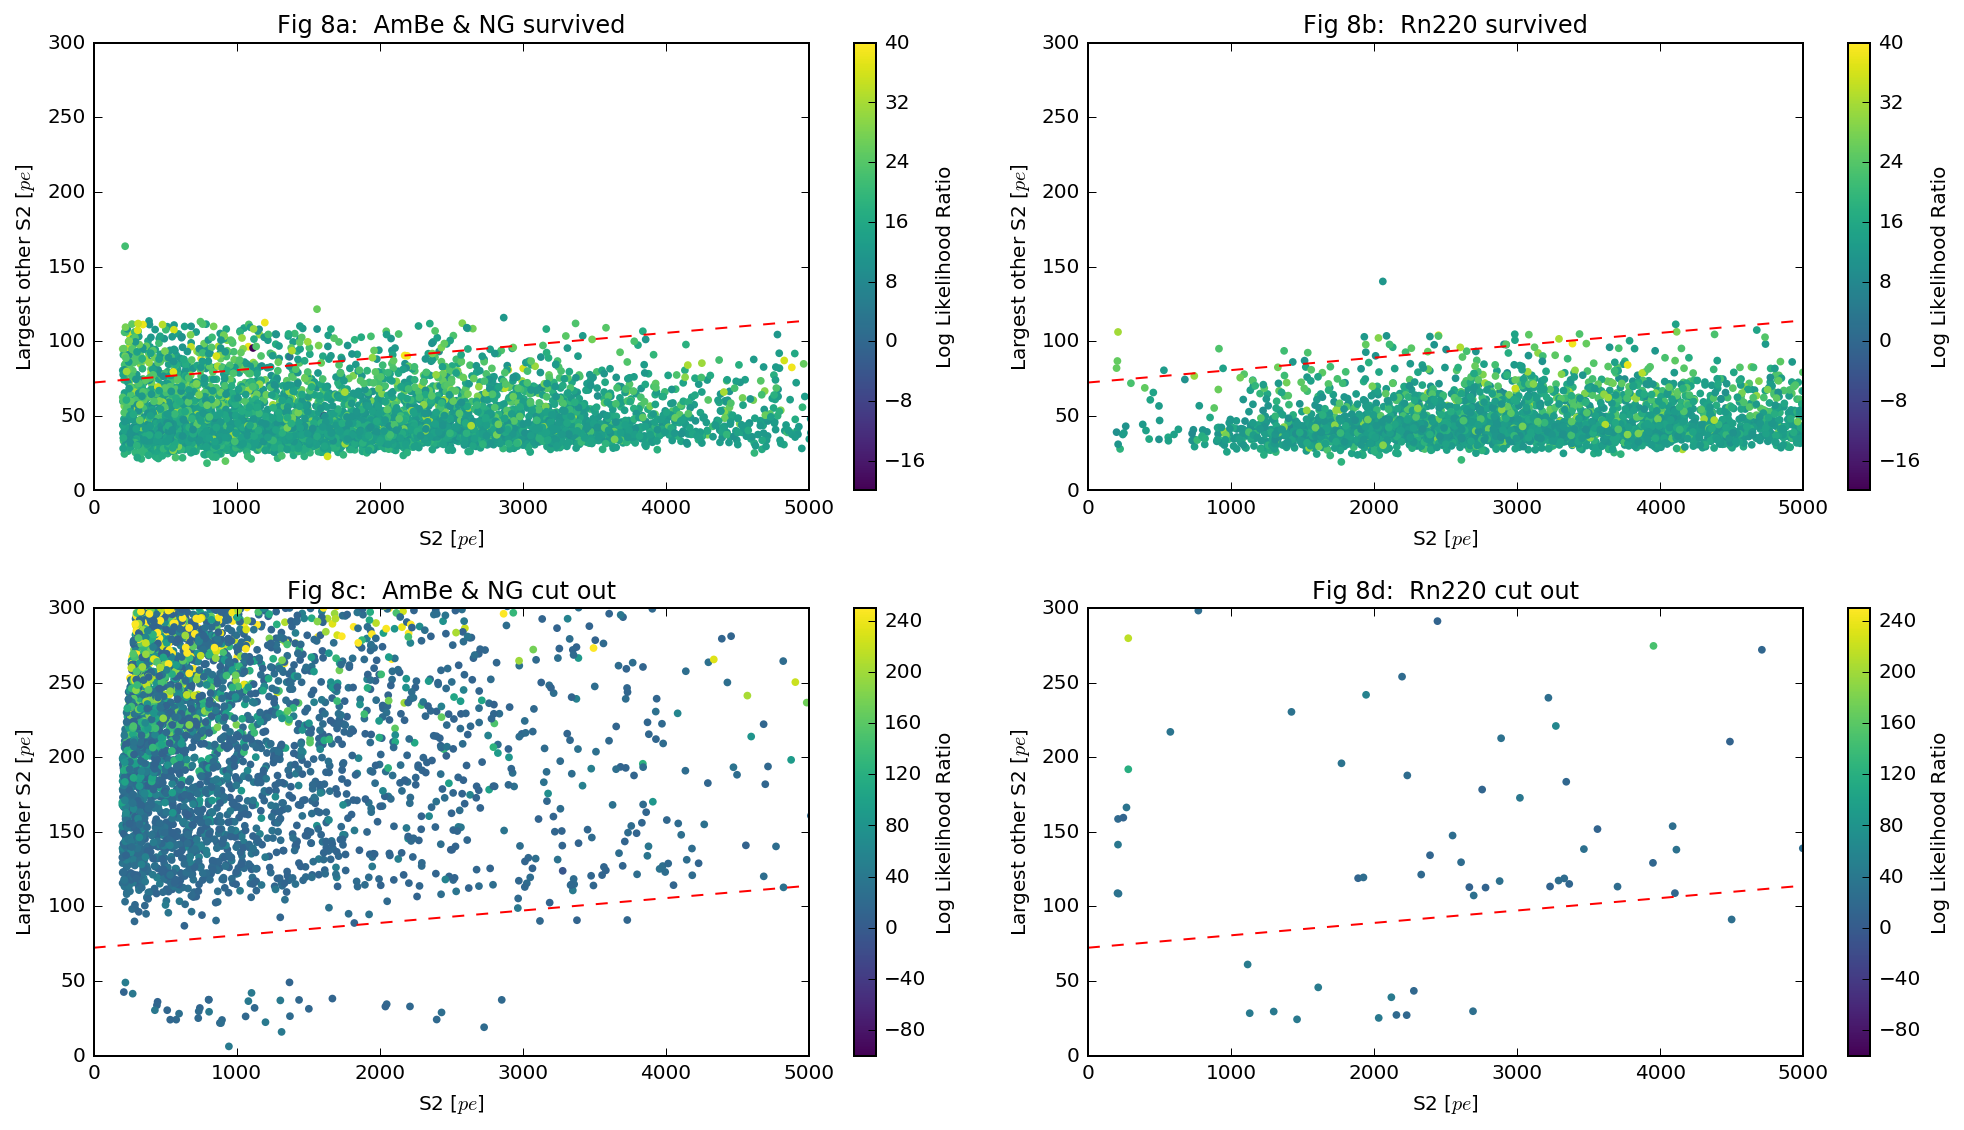

In [16]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
fig = plt.figure()

_show_order = 1
cutoff = 40

peak_order = '1'
s2_range_50p_area = 's2_' + peak_order + '_range_50p_area'
largest_other_s2 = 's2_' + peak_order + '_area'
width_ratio = 's2_' + peak_order + '_width_ratio'

def plotsups():
    x = np.linspace(0,8e3,101)
    plt.plot(x, ses2_size_cut_ori(x), 'r--')

ops = dict(s=15, edgecolor='none', cmap=plt.get_cmap('viridis'))


#####################################################################
ax = fig.add_subplot(221)
df_ = df_nt [(getattr(df_nt, logl[0]) <= cutoff) & 
             (getattr(df_nt, logl[1]) <= cutoff) &
             (getattr(df_nt, logl[2]) <= cutoff)
            ]
plt.scatter(getattr(df_, 's2'), getattr(df_, largest_other_s2),
            c = getattr(df_, logl[_show_order]), vmin = -20, vmax = 40, **ops)
plt_config(title = 'Fig 8a:  AmBe & NG survived', xbounds = [0,5e3], ybounds = [0,300],
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = 'Log Likelihood Ratio', sci = False)
plotsups()

#####################################################################
ax = fig.add_subplot(222)
df_ = df_rn [(getattr(df_rn, logl[0]) <= cutoff) & 
             (getattr(df_rn, logl[1]) <= cutoff) &
             (getattr(df_rn, logl[2]) <= cutoff)
            ]
plt.scatter(getattr(df_, 's2'), getattr(df_, largest_other_s2),
            c = getattr(df_, logl[_show_order]), vmin = -20, vmax = 40, **ops)
plt_config(title = 'Fig 8b:  Rn220 survived', xbounds = [0,5e3], ybounds = [0,300],
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = 'Log Likelihood Ratio', sci = False)
plotsups()

#####################################################################
ax = fig.add_subplot(223)
df_ = df_nt [(getattr(df_nt, logl[0]) > cutoff) | 
             (getattr(df_nt, logl[1]) > cutoff) |
             (getattr(df_nt, logl[2]) > cutoff) |
             False
            ]
plt.scatter(getattr(df_, 's2'), getattr(df_, largest_other_s2),
            c = getattr(df_, logl[_show_order]), vmin = -100, vmax = 250, **ops)
plt_config(title = 'Fig 8c:  AmBe & NG cut out', xbounds = [0,5e3], ybounds = [0,300],
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = 'Log Likelihood Ratio', sci = False)
plotsups()

#####################################################################
ax = fig.add_subplot(224)
df_ = df_rn [(getattr(df_rn, logl[0]) > cutoff) | 
             (getattr(df_rn, logl[1]) > cutoff) |
             (getattr(df_rn, logl[2]) > cutoff) |
             False
            ]
plt.scatter(getattr(df_, 's2'), getattr(df_, largest_other_s2),
            c = getattr(df_, logl[_show_order]), vmin = -100, vmax = 250, **ops)
plt_config(title = 'Fig 8d:  Rn220 cut out', xbounds = [0,5e3], ybounds = [0,300],
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = 'Log Likelihood Ratio', sci = False)

plotsups()
#####################################################################
plt.tight_layout()
plt.show()

##### Next Steps:

1) Investigate cut out events on Rn220 data, my guess is that they are true scatter

2) Check if ms data are removed reasonably 

3) Check se:pile-ups ratio and s2 size dependence, might be possible to further tune cutoff.